## 1.1 Dataset Structure Verification

Before starting the analysis, we needed to check the directory tree and file types. The data follows a relational database structure and is organized into subfolders. The raw data primarily consists of **CSV** and **TXT** files.


In [6]:
import os

folder_path = r"Data"

# Absolute output path
output_file = r"additional_files\tree.txt"

csv_count = 0
txt_count = 0

with open(output_file, "w", encoding="utf-8") as f:
    for root, dirs, files in os.walk(folder_path):
        level = root.replace(folder_path, "").count(os.sep)
        indent = "   " * level
        line = f"{indent}{os.path.basename(root)}/\n"
        print(line, end="")
        f.write(line)

        for file in files:
            line = f"{indent}   {file}\n"
            print(line, end="")
            f.write(line)

            # count CSV and TXT
            if file.lower().endswith(".csv"):
                csv_count += 1
            elif file.lower().endswith(".txt"):
                txt_count += 1

summary = f"\nFound {csv_count} CSV files and {txt_count} TXT files\n"
print(summary)
with open(output_file, "a", encoding="utf-8") as f:
    f.write(summary)

Data/
   Einzelteil_T23.csv
   Einzelteil/
      Einzelteil_T01.txt
      Einzelteil_T02.txt
      Einzelteil_T03.txt
      Einzelteil_T04.csv
      Einzelteil_T05.csv
      Einzelteil_T06.csv
      Einzelteil_T07.txt
      Einzelteil_T08.csv
      Einzelteil_T09.txt
      Einzelteil_T10.csv
      Einzelteil_T11.txt
      Einzelteil_T12.csv
      Einzelteil_T13.csv
      Einzelteil_T14.csv
      Einzelteil_T15.csv
      Einzelteil_T16.txt
      Einzelteil_T17.csv
      Einzelteil_T18.csv
      Einzelteil_T19.csv
      Einzelteil_T20.txt
      Einzelteil_T21.csv
      Einzelteil_T22.txt
      Einzelteil_T23.csv
      Einzelteil_T24.txt
      Einzelteil_T25.csv
      Einzelteil_T26.csv
      Einzelteil_T27.txt
      Einzelteil_T30.csv
      Einzelteil_T31.txt
      Einzelteil_T32.csv
      Einzelteil_T33.csv
      Einzelteil_T34.txt
      Einzelteil_T35.txt
      Einzelteil_T36.txt
      Einzelteil_T37.csv
      Einzelteil_T38.csv
      Einzelteil_T39.txt
      Einzelteil_T40.csv
   Fahr

### Shape & Format Check

After verifying the file types, we inspected the **shapes** and skimmed sample rows to decide how to preprocess them. While row counts look consistent with expectations (e.g., multi-million rows for some *Einzelteil* tables and ~0.3–2.4M rows for others), several files use **unconventional formats**: mixed delimiters (`;`, `,`, `|`, tabs), heavy quoting of headers/values, duplicated “.x/.y” columns from joins, dates in multiple styles (`YYYY-MM-DD`, `DD/MM/YYYY`, and “Origin_01011970” day offsets), decimal **commas** in geodata, and occasional **encoding issues** (UTF-8 decode errors suggesting `latin-1`/`cp1252`).These findings imply a preprocessing step that auto-detects delimiter and encoding, normalizes quoting, converts origin-offsets to real dates, harmonizes decimal separators, and reconciles `.x/.y` duplicates before we compute lead-time metrics.

Additionally, based on the head prints, we identified the ** column set** required to compute part→component→vehicle lead times 

In [7]:
import os
import pandas as pd

folder_path = r"Data"

# Absolute output path (adjust if needed)
output_dir = r"additional_files"
os.makedirs(output_dir, exist_ok=True) 

output_file = os.path.join(output_dir, "file_heads.txt")

def preview_files(root_folder, out_file, limit=200):
    with open(out_file, "w", encoding="utf-8") as out:
        for root, _, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith(".csv") or file.lower().endswith(".txt"):
                    full_path = os.path.join(root, file)
                    head = ""
                    shape_info = ""

                    # Always preview first characters
                    try:
                        with open(full_path, "r", encoding="utf-8", errors="ignore") as f:
                            head = f.read(limit)
                    except Exception as e:
                        head = f"[Error reading file: {e}]"

                    # Only check shape for CSV files
                    if file.lower().endswith(".csv"):
                        try:
                            df = pd.read_csv(full_path, sep=None, engine="python", nrows=5)
                            rows = sum(1 for _ in open(full_path, "r", encoding="utf-8", errors="ignore")) - 1
                            shape_info = f"Shape: ({rows}, {len(df.columns)})"
                        except Exception as e:
                            shape_info = f"[Could not determine shape: {e}]"

                    section = (
                        f"\n--- {full_path} ---\n"
                        f"{head.strip()}\n"
                        f"{shape_info}\n"
                    )
                    print(section)
                    out.write(section)

    print(f"\nPreviews saved to {out_file}")

# Run
preview_files(folder_path,output_file)



--- Data\Einzelteil_T23.csv ---
"";"X1";"ID_T23.x";"Produktionsdatum.x";"Herstellernummer.x";"Werksnummer.x";"Fehlerhaft.x";"Fehlerhaft_Datum.x";"Fehlerhaft_Fahrleistung.x";"ID_T23.y";"Produktionsdatum.y";"Herstellernummer.y";"Werks
Shape: (1908208, 16)


--- Data\Einzelteil\Einzelteil_T01.txt ---
"X1" | | "ID_T01.x" | | "Produktionsdatum.x" | | "Herstellernummer.x" | | "Werksnummer.x" | | "Fehlerhaft.x" | | "Fehlerhaft_Datum.x" | | "Fehlerhaft_Fahrleistung.x" | | "ID_T01.y" | | "Produktionsdat



--- Data\Einzelteil\Einzelteil_T02.txt ---
"X1"  "ID_T02.x"  "Produktionsdatum.x"  "Herstellernummer.x"  "Werksnummer.x"  "Fehlerhaft.x"  "Fehlerhaft_Datum.x"  "Fehlerhaft_Fahrleistung.x"  "ID_T02.y"  "Produktionsdatum.y"  "Herstellernummer.y"



--- Data\Einzelteil\Einzelteil_T03.txt ---
"X1"|"ID_T03"|"Herstellernummer"|"Werksnummer"|"Fehlerhaft"|"Fehlerhaft_Datum"|"Fehlerhaft_Fahrleistung"|"Produktionsdatum_Origin_01011970"|"origin""1"|1|"3-202-2023-249"|"202"|"2023"|0|NA|0|14190|"0



--

## 1.2 Data Parsing

The main workflow is controlled by the `main()` function, which orchestrates verification, file checking, and data parsing. It first prints the target folders (`Einzelteil`, `Fahrzeug`, `Komponente`) and sets up the logging configuration to capture warnings and errors into `process_files.log`.

The function `verify_and_create_directory_structure()` ensures the required folder structure exists. It checks for a `Data` folder in the project directory and creates a `Processed` folder inside it if missing. Each of the target subfolders is also verified. If none are found, the process exits with an error. The function returns paths to the `Data` and `Processed` folders for later use.

The `check_processed_files_exist()` function determines whether all raw files have already been processed. It goes over the target subfolders, counting original CSV and TXT files and comparing them to processed files in the corresponding `Processed` subfolder. TXT files are expected to be converted into CSV during processing. If any files are missing, the system will execute parsing; otherwise, it skips the process and allows direct import.

CSV processing is handled by `process_mangled_csv(input_path, output_path)`. It reads semicolon-delimited CSVs using `pd.read_csv()` with `sep=';'` and `engine='python'`, cleans string columns by stripping quotes, converts numeric columns to proper types, replaces commas with dots in `Fehlerhaft_Fahrleistung`, and standardizes date columns like `Fehlerhaft_Datum` into `dd/mm/YYYY` format. The cleaned DataFrame is then saved as a standard CSV with comma delimiters.

TXT files are processed via `process_txt_file(input_path, output_path)`. This function first detects the most likely delimiter (`pipe`, `tab`, `backslash`, double space, `formfeed`, or custom `II`) by counting occurrences. Tokens are split using `re.split()` with the detected delimiter, and the header is extracted. The data tokens are reshaped into rows and loaded into a `DataFrame`. The function cleans string columns, converts numeric fields, and standardizes date columns similarly to CSV processing. The resulting `DataFrame` is saved as a CSV in the `Processed` folder.

Inside `main()`, for each target subfolder, the workflow lists all CSV and TXT files and applies the appropriate processing function. CSVs with non-semicolon delimiters are copied as-is using `shutil.copy()`. The system keeps track of the number of files processed and prints progress per folder. All exceptions are logged to `process_files.log` without interrupting the entire workflow.

At the end, the script prints a summary indicating whether parsing completed successfully or encountered errors. Successfully processed files are stored in `Data/Processed/` and are ready for subsequent analysis pipelines.

In [13]:
import pandas as pd
import logging
import os
import csv
import shutil
import re

# Logging
logging.basicConfig(
    level=logging.WARNING,
    format='%(message)s',
    handlers=[
        logging.FileHandler('additional_files/process_files.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Target folders
TARGET_FOLDERS = ['Einzelteil', 'Fahrzeug', 'Komponente']


def verify_and_create_structure():
    """
    Verifies the folder structure.
    If Processed/<subfolder> is missing, creates the folder.
    """
    base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
    data_root = os.path.join(base_dir, 'Data')
    processed_root = os.path.join(base_dir, 'Additional_files', 'Processed')

    if not os.path.exists(data_root):
        print(f"ERROR: 'Data' folder not found in {base_dir}")
        return False, None, None

    if not os.path.exists(processed_root):
        os.makedirs(processed_root, exist_ok=True)

    return True, data_root, processed_root


def processed_files_exist(processed_root, subfolder, original_files):
    """
    Checks if all files exist in Processed/<subfolder>.
    """
    processed_folder = os.path.join(processed_root, subfolder)
    if not os.path.exists(processed_folder):
        return False

    for filename in original_files:
        processed_filename = os.path.splitext(filename)[0] + '.csv'
        if not os.path.exists(os.path.join(processed_folder, processed_filename)):
            return False
    return True


def process_mangled_csv(input_path, output_path):
    try:
        df = pd.read_csv(input_path, sep=';', quotechar='"', engine='python', encoding='utf-8-sig')

        cols = list(df.columns)
        if not cols[0] or pd.isna(cols[0]) or str(cols[0]).strip() == '':
            cols[0] = 'Index'
        df.columns = cols

        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype(str).str.replace('"', '').str.strip()

        if 'Fehlerhaft_Fahrleistung' in df.columns:
            df['Fehlerhaft_Fahrleistung'] = df['Fehlerhaft_Fahrleistung'].astype(str).str.replace(',', '.')
            df['Fehlerhaft_Fahrleistung'] = pd.to_numeric(df['Fehlerhaft_Fahrleistung'], errors='coerce')

        numeric_cols = ['Index', 'X1', 'Fehlerhaft', 'Produktionsdatum_Origin_01011970', 'Herstellernummer', 'Werksnummer']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        if 'Fehlerhaft_Datum' in df.columns:
            df['Fehlerhaft_Datum'] = pd.to_datetime(df['Fehlerhaft_Datum'], errors='coerce', format='mixed')
            df['Fehlerhaft_Datum'] = df['Fehlerhaft_Datum'].dt.strftime('%d/%m/%Y')
            df['Fehlerhaft_Datum'] = df['Fehlerhaft_Datum'].fillna('NA')

        df.to_csv(output_path, index=False, sep=',')

    except Exception as e:
        logger.error(f"Error processing {input_path}: {str(e)}")


def process_txt_file(input_path, output_path):
    try:
        with open(input_path, "r", encoding="utf-8", errors="ignore") as f:
            raw_data = f.read()

        delimiter_counts = {
            "pipe": raw_data.count("|"),
            "tab": raw_data.count("\t"),
            "backslash": raw_data.count("\\"),
            "II": raw_data.count("II"),
            "space": raw_data.count("  "),
            "formfeed": raw_data.count("\f")
        }

        detected_delimiter = max(delimiter_counts, key=delimiter_counts.get)
        sep_map = {
            "pipe": r"\|",
            "tab": r"\t",
            "backslash": r"\\",
            "II": r"II",
            "space": r"\s{2,}",
            "formfeed": r"\f"
        }
        sep_regex = sep_map.get(detected_delimiter, r"\s{2,}")

        tokens = [t.strip().strip('"') for t in re.split(sep_regex, raw_data)]
        tokens = [t for t in tokens if t != ""]

        header, i = [], 0
        while i < len(tokens) and not re.match(r"^\d+$", tokens[i]):
            header.append(tokens[i])
            i += 1

        data_tokens = tokens[i:]
        rows = [data_tokens[j:j + len(header)] for j in range(0, len(data_tokens), len(header))]
        df = pd.DataFrame(rows, columns=header)

        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype(str).str.replace('"', '').str.strip()

        if 'Fehlerhaft_Fahrleistung' in df.columns:
            df['Fehlerhaft_Fahrleistung'] = df['Fehlerhaft_Fahrleistung'].astype(str).str.replace(',', '.')
            df['Fehlerhaft_Fahrleistung'] = pd.to_numeric(df['Fehlerhaft_Fahrleistung'], errors='coerce')

        date_cols = ['Fehlerhaft_Datum', 'Produktionsdatum.x', 'Produktionsdatum.y', 'Produktionsdatum']
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce', format='mixed')
                df[col] = df[col].dt.strftime('%d/%m/%Y')
                df[col] = df[col].fillna('NA')

        df.to_csv(output_path, index=False, sep=',')

    except Exception as e:
        logger.error(f"Error processing TXT {input_path}: {str(e)}")


def main():
    print("DATA PARSING SYSTEM")
    print("="*50)
    print(f"Target folders: {', '.join(TARGET_FOLDERS)}\n")

    structure_ok, data_root, processed_root = verify_and_create_structure()
    if not structure_ok:
        return False

    for sub in TARGET_FOLDERS:
        input_folder = os.path.join(data_root, sub)
        output_folder = os.path.join(processed_root, sub)

        if not os.path.exists(input_folder):
            print(f"Folder missing: {input_folder}")
            continue

        files_to_process = [
            f for f in os.listdir(input_folder)
            if f.lower().endswith((".csv", ".txt")) and os.path.isfile(os.path.join(input_folder, f))
        ]

        if not files_to_process:
            print(f"   No CSV/TXT files found in {sub}")
            continue

        if processed_files_exist(processed_root, sub, files_to_process):
            print(f"{sub}: files already processed, skipping.")
            continue

        os.makedirs(output_folder, exist_ok=True)
        print(f"{sub}: starting parsing of {len(files_to_process)} files...")

        for filename in files_to_process:
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.csv')

            if filename.lower().endswith('.csv'):
                try:
                    with open(input_path, 'r', encoding='utf-8-sig') as f:
                        sample = f.read(1024)
                        dialect = csv.Sniffer().sniff(sample)

                    if dialect.delimiter == ';':
                        process_mangled_csv(input_path, output_path)
                    else:
                        shutil.copy(input_path, output_path)
                except Exception as e:
                    print(f"   Error processing CSV {filename}: {str(e)}")

            elif filename.lower().endswith('.txt'):
                process_txt_file(input_path, output_path)

        print(f"{sub}: parsing completed.")

    print("\nProcessing complete!")
    return True


if __name__ == "__main__":
    result = main()

    if result:
        print("\n" + "="*80)
        print("PARSING COMPLETED SUCCESSFULLY")
        print("Files saved in: Additional_files/Processed/")
        print("="*80)
    else:
        print("\n" + "="*80)
        print("ERROR DURING PARSING")
        print("Check the logs for details.")
        print("="*80)


DATA PARSING SYSTEM
Target folders: Einzelteil, Fahrzeug, Komponente

Einzelteil: files already processed, skipping.
Fahrzeug: files already processed, skipping.
Komponente: files already processed, skipping.

Processing complete!

PARSING COMPLETED SUCCESSFULLY
Files saved in: Additional_files/Processed/


## 1.3 - Data Import
After parsing the raw files, the next step is to ensure that the processed data is accessible for analysis. The script defines a data path using `os.path.join(".", "Data", "Processed")` to maintain cross-platform compatibility. This path points to the folder containing all pre-processed files.

The script first verifies whether the path exists and is a directory using `os.path.exists()` and `os.path.isdir()`. If the folder is found, a confirmation message is printed, indicating that the processed data is ready for use.

If the path does not exist, the script checks whether the parent `Data` folder exists. If `Data` exists, it prints its contents to help diagnose missing subfolders or misnamed directories. If neither the `Processed` subfolder nor the `Data` folder exists, an error message is printed, and a `FileNotFoundError` is raised to halt further execution. This ensures that downstream analysis does not attempt to load non-existent data.



In [14]:
import os

# Define data path using os.path.join for cross-platform compatibility
DATA_PATH = os.path.join(".", "Additional_files", "Processed")

# Verify that the path exists
if os.path.exists(DATA_PATH) and os.path.isdir(DATA_PATH):
    print(f"Data path exists: {DATA_PATH}")
else:
    print(f"ERROR: The specified path does not exist: {DATA_PATH}")
    # Check if the Data folder exists
    data_folder = os.path.join(".", "Data")
    if os.path.exists(data_folder):
        print(f"Data folder exists: {data_folder}")
        print("Contents of the Data folder:")
        for item in os.listdir(data_folder):
            print(f"  - {item}")
    else:
        print(f"ERROR: Data folder does not exist: {data_folder}")
    
    raise FileNotFoundError(f"ERROR: The specified path does not exist: {DATA_PATH}. Please verify the path.")

Data path exists: .\Additional_files\Processed


In [3]:
from pathlib import Path
import pandas as pd
import warnings

# Suppress DtypeWarning
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

def load_file_safe(filepath, separator=',', encoding='utf-8'):
    """Safely loads a CSV file."""
    try:
        return pd.read_csv(filepath, sep=separator, encoding=encoding, na_values=['NA'], on_bad_lines='skip', low_memory=False)
    except Exception as e:
        print(f"ERROR: Failed to load {filepath}: {e}")
        return None


def load_all_datasets(data_path):
    """Loads all relevant datasets from the PROCESSED folder."""
    datasets = {
        'einzelteil': {},
        'komponente': {},
        'fahrzeug': {},
        'bestandteile fahrzeug': {},
        'bestandteile komponente': {}
    }
    
    # ---------- EINZELTEIL ----------
    einzelteil_path = Path(data_path) / "Einzelteil"
    if einzelteil_path.exists():
        for file in einzelteil_path.glob("Einzelteil_T*.csv"):
            part_name = file.stem.replace("Einzelteil_", "")
            datasets['einzelteil'][part_name] = load_file_safe(file)

    # ---------- KOMPONENTE AND BESTANDTEILE ----------
    komponente_path = Path(data_path) / "Komponente"
    if komponente_path.exists():
        for file in komponente_path.glob("Komponente*.csv"):
            comp_name = file.stem.replace("Komponente_", "")
            datasets['komponente'][comp_name] = load_file_safe(file)
        for file in komponente_path.glob("Bestandteile_*.csv"):
            bestand_name = file.stem.replace("Bestandteile_", "")
            datasets['bestandteile komponente'][bestand_name] = load_file_safe(file)
    
    # ---------- FAHRZEUG AND BESTANDTEILE ----------
    fahrzeug_path = Path(data_path) / "Fahrzeug"
    if fahrzeug_path.exists():
        for file in fahrzeug_path.glob("Fahrzeuge_*.csv"):
            vehicle_name = file.stem.replace("Fahrzeuge_", "")
            datasets['fahrzeug'][vehicle_name] = load_file_safe(file)
        
        for file in fahrzeug_path.glob("Bestandteile_*.csv"):
            bestand_name = file.stem.replace("Bestandteile_", "")
            datasets['bestandteile fahrzeug'][bestand_name] = load_file_safe(file)
    
    return datasets


# Load the data
all_datasets = load_all_datasets(DATA_PATH)

# Print only successfully loaded files with shape information
for category, files in all_datasets.items():
    for name, df in files.items():
        if df is not None:
            print(f"LOADED: {category.upper()}_{name}: {df.shape[0]} rows × {df.shape[1]} columns")

LOADED: EINZELTEIL_T01: 3204104 rows × 22 columns
LOADED: EINZELTEIL_T02: 3204104 rows × 15 columns
LOADED: EINZELTEIL_T03: 1192630 rows × 9 columns
LOADED: EINZELTEIL_T04: 1192630 rows × 10 columns
LOADED: EINZELTEIL_T05: 1192630 rows × 16 columns
LOADED: EINZELTEIL_T06: 1192630 rows × 10 columns
LOADED: EINZELTEIL_T07: 409422 rows × 9 columns
LOADED: EINZELTEIL_T08: 409422 rows × 10 columns
LOADED: EINZELTEIL_T09: 409422 rows × 15 columns
LOADED: EINZELTEIL_T10: 409422 rows × 10 columns
LOADED: EINZELTEIL_T11: 2385260 rows × 9 columns
LOADED: EINZELTEIL_T12: 1908208 rows × 23 columns
LOADED: EINZELTEIL_T13: 1908208 rows × 10 columns
LOADED: EINZELTEIL_T14: 477052 rows × 10 columns
LOADED: EINZELTEIL_T15: 477052 rows × 16 columns
LOADED: EINZELTEIL_T16: 818844 rows × 22 columns
LOADED: EINZELTEIL_T17: 655075 rows × 23 columns
LOADED: EINZELTEIL_T18: 655075 rows × 10 columns
LOADED: EINZELTEIL_T19: 163769 rows × 10 columns
LOADED: EINZELTEIL_T20: 163769 rows × 9 columns
LOADED: EINZELT

## 2.1 Data Exploration

After loading the processed datasets, the next step is to perform a structured exploratory analysis to understand their content and quality.

The function `explore_dataset(df, dataset_name)` examines a single `pandas.DataFrame` and returns a dictionary with key metadata: the dataset shape (`df.shape`), column names, data types (`df.dtypes.to_dict()`), missing values (`df.isnull().sum().to_dict()`), memory usage (`df.memory_usage(deep=True).sum()`), and subsets of numeric, object, and datetime columns identified using `df.select_dtypes()`. For numeric columns, it generates descriptive statistics with `df.describe().to_dict()`. For object columns, it records the number of unique values, the most frequent entry (`df[col].mode()`), and a sample of up to five unique values.

The helper function `find_similar_columns(all_explorations)` identifies common attributes across datasets. It normalizes column names using `re.sub()` to remove suffixes such as `.x`, `.y`, `_Origin_n`, or numeric endings, then groups columns by their cleaned root names and returns only groups that occur in multiple datasets.

The main routine, `analyze_all_datasets(all_datasets)`, does the analysis. It iterates over each dataset, calling `explore_dataset()`, and prints detailed information including row/column counts, memory usage in MB, missing-value counts with percentages, counts of numeric/text/datetime columns, and the first three rows (`df.head(3).to_string()`). Missing values are aggregated globally using a `defaultdict(int)`. After analyzing all datasets, it prints a summary that includes the total number of loaded files, per-category counts, global missing-value statistics, groups of similar columns from `find_similar_columns()`, and overall data type frequencies across all datasets.

Executing this script provides detailed per-dataset reports and a comprehensive summary. It also returns three key objects: a list of exploration results for each dataset, a dictionary of similar column groupings, and counts of datasets per category.

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re

def explore_dataset(df, dataset_name):
    """
    Explore a single dataset and return main information
    """
    if df is None or df.empty:
        return None
        
    exploration = {
        'name': dataset_name,
        'shape': df.shape,
        'columns': list(df.columns),
        'column_types': df.dtypes.to_dict(),
        'missing_values': df.isnull().sum().to_dict(),
        'memory_usage': df.memory_usage(deep=True).sum(),
        'numeric_columns': list(df.select_dtypes(include=[np.number]).columns),
        'object_columns': list(df.select_dtypes(include=['object']).columns),
        'datetime_columns': list(df.select_dtypes(include=['datetime64']).columns)
    }
    
    # Statistics for numeric columns
    if exploration['numeric_columns']:
        exploration['numeric_stats'] = df[exploration['numeric_columns']].describe().to_dict()
    
    # Information on text columns
    if exploration['object_columns']:
        object_info = {}
        for col in exploration['object_columns']:
            unique_count = df[col].nunique()
            object_info[col] = {
                'unique_values': unique_count,
                'most_frequent': df[col].mode().iloc[0] if not df[col].mode().empty else None,
                'sample_values': df[col].dropna().unique()[:5].tolist() if unique_count > 0 else []
            }
        exploration['object_info'] = object_info
    
    return exploration

def find_similar_columns(all_explorations):
    """
    Find columns with similar names across all datasets
    """
    all_columns = []
    for exploration in all_explorations:
        if exploration:
            for col in exploration['columns']:
                all_columns.append((col, exploration['name']))
    
    similar_groups = defaultdict(list)
    
    # Group by common root
    for col, dataset in all_columns:
        # Remove common suffixes like .x, .y, _Origin_etc
        clean_col = re.sub(r'\.(x|y)$|_Origin_\d+$|_\d+$', '', col)
        similar_groups[clean_col].append((col, dataset))
    
    # Filter only groups with more than one element
    return {k: v for k, v in similar_groups.items() if len(v) > 1}

def analyze_all_datasets(all_datasets):
    """
    Analyze all loaded datasets
    """
    print("="*80)
    print("COMPREHENSIVE ANALYSIS OF LOADED DATASETS")
    print("="*80)
    
    all_explorations = []
    category_stats = defaultdict(int)
    all_missing_by_column = defaultdict(int)
    
    # Explore each dataset
    for category, datasets in all_datasets.items():
        print(f"\nCATEGORY: {category.upper()}")
        print("-" * 50)
        
        if not datasets:
            print("No datasets loaded in this category")
            continue
            
        category_stats[category] = len([df for df in datasets.values() if df is not None])
        
        for name, df in datasets.items():
            if df is not None:
                exploration = explore_dataset(df, f"{category}_{name}")
                all_explorations.append(exploration)
                
                # Accumulate missing values by column name across all datasets
                for col, missing_count in exploration['missing_values'].items():
                    all_missing_by_column[col] += missing_count
                
                print(f"\nDataset: {name}")
                print(f"   Dimensions: {exploration['shape'][0]:,} rows × {exploration['shape'][1]} columns")
                print(f"   Memory used: {exploration['memory_usage']/1024/1024:.2f} MB")
                
                # Show missing values per column for this dataset
                missing_values = {k: v for k, v in exploration['missing_values'].items() if v > 0}
                if missing_values:
                    print(f"   Missing values per column:")
                    for col, count in sorted(missing_values.items(), key=lambda x: x[1], reverse=True):
                        percentage = (count / exploration['shape'][0]) * 100
                        print(f"      - {col}: {count:,} ({percentage:.1f}%)")
                else:
                    print(f"   No missing values in this dataset")
                
                print(f"   Column types:")
                print(f"      - Numeric: {len(exploration['numeric_columns'])}")
                print(f"      - Text: {len(exploration['object_columns'])}")
                print(f"      - Dates: {len(exploration['datetime_columns'])}")
                
                # Show dataset head (first 3 rows)
                print(f"   Dataset head (first 3 rows):")
                print(df.head(3).to_string())
                
            else:
                print(f"ERROR: {name}: Loading failed")
    
    # General summary
    print("\n" + "="*80)
    print("GENERAL SUMMARY")
    print("="*80)
    
    total_files = sum(category_stats.values())
    print(f"Total number of loaded files: {total_files}")
    print(f"Files per category:")
    for category, count in category_stats.items():
        print(f"   - {category}: {count} files")
    
    # Show missing values by column across all datasets
    print(f"\nMISSING VALUES BY COLUMN (across all datasets):")
    print("-" * 50)
    if all_missing_by_column:
        sorted_missing = sorted(all_missing_by_column.items(), key=lambda x: x[1], reverse=True)
        for col, total_missing in sorted_missing:
            if total_missing > 0:
                print(f"   - {col}: {total_missing:,} missing values")
    else:
        print("No missing values found across all datasets")
    
    # Find similar columns
    print(f"\nCOLUMNS WITH SIMILAR NAMES:")
    print("-" * 50)
    similar_columns = find_similar_columns(all_explorations)
    
    if similar_columns:
        for base_name, occurrences in similar_columns.items():
            if len(occurrences) > 1:
                print(f"\nRoot: '{base_name}'")
                for col_name, dataset_name in occurrences:
                    print(f"   - {col_name} (in {dataset_name})")
    else:
        print("No columns with similar names found")
    
    # Data types analysis
    print(f"\nDATA TYPES ANALYSIS:")
    print("-" * 50)
    all_column_types = defaultdict(int)
    for exploration in all_explorations:
        if exploration:
            for col_type in exploration['column_types'].values():
                all_column_types[str(col_type)] += 1
    
    for dtype, count in sorted(all_column_types.items(), key=lambda x: x[1], reverse=True):
        print(f"   - {dtype}: {count} columns")
    
    return all_explorations, similar_columns, category_stats

# Execute comprehensive analysis
explorations, similar_cols, stats = analyze_all_datasets(all_datasets)

COMPLETE ANALYSIS OF LOADED DATASETS

CATEGORY: EINZELTEIL
--------------------------------------------------

Dataset: T01
   Dimensions: 3,204,104 rows × 22 columns
   Memory used: 1636.30 MB
   Missing values per column:
      - Fehlerhaft_Datum: 3,075,728 (96.0%)
      - Fehlerhaft_Datum.y: 2,948,080 (92.0%)
      - Fehlerhaft_Datum.x: 2,884,176 (90.0%)
      - ID_T01: 2,563,284 (80.0%)
      - Produktionsdatum: 2,563,284 (80.0%)
      - Herstellernummer: 2,563,284 (80.0%)
      - Werksnummer: 2,563,284 (80.0%)
      - Fehlerhaft: 2,563,284 (80.0%)
      - ID_T01.x: 1,922,462 (60.0%)
      - Produktionsdatum.x: 1,922,462 (60.0%)
      - Herstellernummer.x: 1,922,462 (60.0%)
      - Werksnummer.x: 1,922,462 (60.0%)
      - Fehlerhaft.x: 1,922,462 (60.0%)
      - Fehlerhaft_Fahrleistung.x: 1,922,462 (60.0%)
      - ID_T01.y: 1,922,462 (60.0%)
      - Produktionsdatum.y: 1,922,462 (60.0%)
      - Herstellernummer.y: 1,922,462 (60.0%)
      - Werksnummer.y: 1,922,462 (60.0%)
      - Fe

 ## 2.2 - Data Preparation
Following the exploratory analysis, the next step is structured preprocessing of all datasets to ensure consistency and readiness for downstream operations.

The function `clean_column_names(df: pd.DataFrame)` standardizes column headers by removing unwanted characters such as quotes and newline symbols using `str.strip()` and `str.replace()`.

`unify_column_names(df: pd.DataFrame)` merges duplicate columns with suffixes like `.x`, `.y`, or `_Origin_n`. It first replaces empty values with `NaN` using `df.replace()`, then defines a `rename_map` for known duplicate groups such as `"Produktionsdatum"`, `"Herstellernummer"`, and `"Werksnummer"`. ID columns are automatically grouped. Column values are unified using a vectorized `bfill(axis=1)` across variants, which is more efficient than iterative `combine_first`.

`convert_production_date(df: pd.DataFrame)` normalizes all `"Produktionsdatum"` columns. Multiple variants are merged using `bfill(axis=1)`, then parsed vectorially. ISO style `YYYY-MM-DD` strings are parsed with `pd.to_datetime(format='%Y-%m-%d')`. Remaining values are interpreted with `dayfirst=True`. Numeric encodings are supported: large integers are treated as `YYYYMMDD` dates, and small integers as days offset from `1970-01-01`. Results are consolidated into a single `"Produktionsdatum"` column.

The function `light_preprocessing(df: pd.DataFrame, category: str, name: str)` applies a preprocessing sequence which corresponds to dataset type. For `"einzelteil"`, `"komponente"`, and `"fahrzeug"`, it cleans column names, unifies duplicates, converts dates, and keeps essential columns (`"ID"`, `"Produktionsdatum"`, `"Herstellernummer"`, `"Werksnummer"`), with a fallback subset if some are missing. For `"bestandteile komponente"` and `"bestandteile fahrzeug"`, it keeps all `"ID"` columns or the first two columns as a fallback. Metadata columns `"Dataset_Category"` and `"Dataset_Name"` are always appended.

The main routine `process_and_display_all_datasets(all_datasets: dict)` initializes preprocessing across all dataset categories. It counts total datasets, iterates through each category, and applies `light_preprocessing` to each file. Successfully processed datasets are stored in a `processed` dictionary under their category. Console output shows progress with dataset name, row count, and column count. Errors or empty results are logged as warnings.

Execution begins with a runtime measurement via `time.time()`. Calling  `processed_datasets = process_and_display_all_datasets(all_datasets)`  triggers preprocessing, and after completion, the script prints total execution time in seconds.



In [6]:
import pandas as pd
import numpy as np

# ---------------------------
# Preprocessing functions
# ---------------------------

def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Remove unwanted characters from column names."""
    df.columns = [col.strip().strip('"').replace('\n', '').replace('\r', '') for col in df.columns]
    return df

def unify_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges duplicate columns (.x, .y, without suffix).
    Maintains the same logic as the original but with better performance.
    """
    # Convert common "empty" values to NaN for preprocessing
    df_work = df.replace(["nan", "NA", "", "0"], np.nan)
    
    # Mapping to unify duplicate columns
    rename_map = {
        'Produktionsdatum': [
            'Produktionsdatum',
            'Produktionsdatum.x', 
            'Produktionsdatum.y',
            'Produktionsdatum_Origin_01011970'
        ],
        'Herstellernummer': ['Herstellernummer', 'Herstellernummer.x', 'Herstellernummer.y'],
        'Werksnummer': ['Werksnummer', 'Werksnummer.x', 'Werksnummer.y'],
        'Fehlerhaft': ['Fehlerhaft', 'Fehlerhaft.x', 'Fehlerhaft.y'],
        'Fehlerhaft_Datum': ['Fehlerhaft_Datum', 'Fehlerhaft_Datum.x', 'Fehlerhaft_Datum.y'],
        'Fehlerhaft_Fahrleistung': ['Fehlerhaft_Fahrleistung', 'Fehlerhaft_Fahrleistung.x', 'Fehlerhaft_Fahrleistung.y']
    }
    
    # Automatically add all ID columns
    id_columns = [col for col in df_work.columns if col.startswith('ID')]
    if id_columns:
        rename_map['ID'] = id_columns

    new_df = pd.DataFrame(index=df_work.index)
    used_cols = set()
    
    # Process each group of columns
    for final_name, variants in rename_map.items():
        cols_present = [col for col in variants if col in df_work.columns]
        if not cols_present:
            continue
            
        # Use vectorized bfill instead of iterative combine_first
        if len(cols_present) == 1:
            new_df[final_name] = df_work[cols_present[0]]
        else:
            # Vectorized method: bfill across columns
            new_df[final_name] = df_work[cols_present].bfill(axis=1).iloc[:, 0]
        
        used_cols.update(cols_present)

    # Add remaining columns
    remaining_cols = [col for col in df_work.columns if col not in used_cols]
    for col in remaining_cols:
        new_df[col] = df_work[col]

    return new_df

def convert_production_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Date conversion with comprehensive handling.
    Maintains the same logic but with better performance.
    """
    # Find all date columns
    date_cols = [c for c in df.columns if c.startswith('Produktionsdatum')]
    if not date_cols:
        return df

    # If we have multiple columns, use unification logic
    if len(date_cols) > 1:
        # Unify date columns first
        combined = df[date_cols].bfill(axis=1).iloc[:, 0]
    else:
        combined = df[date_cols[0]]

    # Vectorized cleaning
    combined_str = combined.astype(str).str.replace(r'[\s"\x0b]', '', regex=True)

    # Initialize result series
    converted = pd.Series(pd.NaT, index=combined.index, dtype='datetime64[ns]')

    # Step 1: Try to identify and parse YYYY-MM-DD format FIRST (before dayfirst conversion)
    yyyy_mm_dd_mask = combined_str.str.match(r'^\d{4}-\d{1,2}-\d{1,2}$', na=False)
    if yyyy_mm_dd_mask.any():
        yyyy_mm_dd_values = combined_str[yyyy_mm_dd_mask]
        # Parse with explicit format to avoid ambiguity
        converted.loc[yyyy_mm_dd_mask] = pd.to_datetime(
            yyyy_mm_dd_values, 
            format='%Y-%m-%d', 
            errors='coerce'
        )

    # Step 2: For remaining unconverted values, try standard conversion with dayfirst=True
    mask_unconverted = converted.isna() & combined_str.notna() & (combined_str != 'nan')
    
    if mask_unconverted.any():
        unconverted_series = combined_str[mask_unconverted]
        
        # Try standard datetime conversion for other formats
        standard_converted = pd.to_datetime(unconverted_series, errors='coerce', dayfirst=True)
        valid_standard = standard_converted.notna()
        if valid_standard.any():
            converted.loc[unconverted_series[valid_standard].index] = standard_converted[valid_standard]

    # Step 3: Handle remaining numeric values
    mask_still_unconverted = converted.isna() & combined_str.notna() & (combined_str != 'nan')
    
    if mask_still_unconverted.any():
        still_unconverted = combined_str[mask_still_unconverted]
        
        # Vectorized numeric conversion
        numeric_vals = pd.to_numeric(still_unconverted, errors='coerce')
        numeric_mask = numeric_vals.notna()
        
        if numeric_mask.any():
            # Large numbers → YYYYMMDD
            large_numbers = numeric_vals[numeric_mask & (numeric_vals > 10_000_000)]
            if len(large_numbers) > 0:
                dates_from_yyyymmdd = pd.to_datetime(
                    large_numbers.astype(int).astype(str),
                    format='%Y%m%d', errors='coerce'
                )
                converted.loc[large_numbers.index] = dates_from_yyyymmdd

            # Small numbers → days from 1970
            small_numbers = numeric_vals[numeric_mask & (numeric_vals <= 10_000_000)]
            if len(small_numbers) > 0:
                base_date = pd.Timestamp('1970-01-01')
                days_to_add = pd.to_timedelta(small_numbers.astype(int), unit='D')
                converted.loc[small_numbers.index] = base_date + days_to_add

    df['Produktionsdatum'] = converted
    return df

def light_preprocessing(df: pd.DataFrame, category: str, name: str) -> pd.DataFrame:
    """
    Standard preprocessing that maintains all functionalities.
    """
    if df is None or df.empty:
        return None

    # Step 1: Clean column names
    df_clean = clean_column_names(df.copy())

    if category in ['einzelteil', 'komponente', 'fahrzeug']:
        # Step 2: Unify duplicate columns
        df_clean = unify_column_names(df_clean)
        
        # Step 3: Convert dates
        df_clean = convert_production_date(df_clean)

        # Step 4: Select essential columns
        essential_cols = ['ID', 'Produktionsdatum', 'Herstellernummer', 'Werksnummer']
        available_cols = [col for col in essential_cols if col in df_clean.columns]
        
        if available_cols:
            df_clean = df_clean[available_cols]
        else:
            # Fallback: keep first columns if no essential ones are found
            df_clean = df_clean.iloc[:, :min(4, df_clean.shape[1])]

    elif category in ['bestandteile komponente', 'bestandteile fahrzeug']:
        # Keep all columns containing "ID"
        id_cols = [col for col in df_clean.columns if "ID" in col]
        if id_cols:
            df_clean = df_clean[id_cols]
        else:
            # Fallback: first 2 columns
            df_clean = df_clean.iloc[:, :min(2, df_clean.shape[1])]

    # Add metadata
    df_clean['Dataset_Category'] = category
    df_clean['Dataset_Name'] = name

    return df_clean

# ---------------------------
# Main function
# ---------------------------

def process_and_display_all_datasets(all_datasets: dict) -> dict:
    """
    Processes all datasets with comprehensive preprocessing.
    """
    processed = {}
    total_datasets = sum(len(files) for files in all_datasets.values() if files)
    current_count = 0

    print(f"Starting preprocessing of {total_datasets} datasets...")

    for category, files in all_datasets.items():
        if not files:
            continue

        processed[category] = {}
        print(f"\nProcessing {category.upper()} ({len(files)} files)...")

        for name, df in files.items():
            current_count += 1
            if df is not None and not df.empty:
                try:
                    processed_df = light_preprocessing(df, category, name)
                    if processed_df is not None and not processed_df.empty:
                        processed[category][name] = processed_df
                        print(f"SUCCESS [{current_count}/{total_datasets}] {category.upper()}_{name}: {processed_df.shape[0]} rows × {processed_df.shape[1]} columns")
                    else:
                        print(f"WARNING [{current_count}/{total_datasets}] {category.upper()}_{name}: Dataset empty after preprocessing")
                except Exception as e:
                    print(f"ERROR [{current_count}/{total_datasets}] {category.upper()}_{name}: Error - {str(e)}")
            else:
                print(f"WARNING [{current_count}/{total_datasets}] {category.upper()}_{name}: Dataset empty or None")

    print(f"\nPreprocessing completed! Processed {current_count} datasets.")
    return processed

# ---------------------------
# EXECUTION
# ---------------------------
print("Starting preprocessing on all datasets...")
import time
start_time = time.time()

processed_datasets = process_and_display_all_datasets(all_datasets)

end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

Starting OPTIMIZED preprocessing on all datasets...
Starting optimized preprocessing of 79 datasets...

Processing EINZELTEIL (38 files)...
✅ [1/79] EINZELTEIL_T01: 3204104 rows × 6 columns
✅ [1/79] EINZELTEIL_T01: 3204104 rows × 6 columns
✅ [2/79] EINZELTEIL_T02: 3204104 rows × 6 columns
✅ [2/79] EINZELTEIL_T02: 3204104 rows × 6 columns
✅ [3/79] EINZELTEIL_T03: 1192630 rows × 6 columns
✅ [3/79] EINZELTEIL_T03: 1192630 rows × 6 columns
✅ [4/79] EINZELTEIL_T04: 1192630 rows × 6 columns
✅ [4/79] EINZELTEIL_T04: 1192630 rows × 6 columns
✅ [5/79] EINZELTEIL_T05: 1192630 rows × 6 columns
✅ [5/79] EINZELTEIL_T05: 1192630 rows × 6 columns
✅ [6/79] EINZELTEIL_T06: 1192630 rows × 6 columns
✅ [6/79] EINZELTEIL_T06: 1192630 rows × 6 columns
✅ [7/79] EINZELTEIL_T07: 409422 rows × 6 columns
✅ [7/79] EINZELTEIL_T07: 409422 rows × 6 columns
✅ [8/79] EINZELTEIL_T08: 409422 rows × 6 columns
✅ [8/79] EINZELTEIL_T08: 409422 rows × 6 columns
✅ [9/79] EINZELTEIL_T09: 409422 rows × 6 columns
✅ [9/79] EINZEL

## 3 - Final Dataset Creation
The final step in the workflow is the creation of a comprehensive supply chain dataset that links sampled vehicles with their components and parts, including computed lead times.

The main function `run_supply_chain_pipeline(processed_datasets, group_number=40, sample_percentage=SAMPLE_PERCENTAGE)` orchestrates the pipeline. It begins by verifying that all required dataset categories (`'fahrzeug'`, `'komponente'`, `'einzelteil'`, `'bestandteile fahrzeug'`, `'bestandteile komponente'`) exist in `processed_datasets`. Any missing categories are reported, and the function exits if critical datasets are absent.

In STEP 1, vehicles are filtered and sampled. Only vehicles containing a `Produktionsdatum` are considered. Sampling is performed using `df.sample(n=sample_size, random_state=42)`, where `sample_size` is calculated from `SAMPLE_PERCENTAGE` (default 1%). Successfully sampled vehicles are stored in `vehicle_samples`, and datasets missing the required column are logged and excluded.

STEP 2 constructs lookup tables for components and parts. Component IDs referenced by sampled vehicles are retrieved from `'bestandteile fahrzeug'` using column matching (`ID_Fahrzeug` and columns starting with `ID_`). Metadata for components (`ID`, `Produktionsdatum`, `Herstellernummer`, `Werksnummer`, component type) is stored in `komponente_lookup`. Part IDs are similarly retrieved from `'bestandteile komponente'` and stored in `einzelteil_lookup`. Only entries actually used by sampled vehicles are included.

STEP 3 reconstructs the vehicle → components → parts mapping. Dictionaries `vehicle_to_komponente` and `komponente_to_einzelteil` map vehicles to their components and components to their parts, respectively. Mappings are built by iterating over the relevant datasets and filtering for the sampled IDs.

STEP 4 calculates lead times and assembles the final dataset. For each sampled vehicle, a record is initialized with fixed columns (`ID_Fahrzeug`, `Vehicle_Prod_Date`, `Earliest_Part_Date`, `Days_Diff`, `Source_Table`) and additional columns for each component in `TARGET_COMPONENTS` (`Karosserie`, `Schaltung`, `Sitze`, `Motor`). For each component, production dates are recorded, and earliest/latest part production dates and IDs are identified. Lead time is computed as the difference in days between the component production date and the earliest part production date. Global earliest part dates and overall `Days_Diff` per vehicle are also calculated.

Finally, a DataFrame `final_df` is created from all records with a predefined column order. The dataset is saved to CSV (`Final_dataset_group_{group_number}.csv`), and summary information—including number of rows, columns, and column names—is printed. If no records are generated, an error is reported.

The pipeline is executed with:  
```python
final_dataset = run_supply_chain_pipeline(processed_datasets, group_number=40)


In [17]:
import pandas as pd
import numpy as np
from collections import defaultdict

# --- Sampling parameter ---
SAMPLE_PERCENTAGE = 0.01 # 1%, modifiable

# --- Target components ---
TARGET_COMPONENTS = ['Karosserie', 'Schaltung', 'Sitze', 'Motor']

# --- Main function ---
def run_supply_chain_pipeline(processed_datasets, group_number=40, sample_percentage=SAMPLE_PERCENTAGE):
    """
    Generates the final dataset with vehicle sampling and component/part leadtimes.
    """
    # 1. Verify data in memory
    required_keys = ['fahrzeug', 'komponente', 'einzelteil', 'bestandteile fahrzeug', 'bestandteile komponente']
    print("Verifying datasets in memory...")
    missing_keys = [k for k in required_keys if k not in processed_datasets]
    if missing_keys:
        print(f"ERROR: Missing the following datasets in processed_datasets: {missing_keys}")
        return None
    print("All required datasets present.\n")
    
    # 2. Filter and sample vehicles (only those with Produktionsdatum)
    print(f"STEP 1: Filter and sample vehicles (percentage: {sample_percentage*100:.1f}%)")
    vehicle_samples = {}
    total_before, total_after = 0, 0
    excluded_datasets = []
    
    for vehicle_type, df in processed_datasets['fahrzeug'].items():
        if df is not None and not df.empty:
            # Check if DataFrame has Produktionsdatum column
            if 'Produktionsdatum' not in df.columns:
                excluded_datasets.append(vehicle_type)
                print(f"  ERROR: {vehicle_type}: EXCLUDED (missing Produktionsdatum column)")
                continue
                
            sample_size = max(1, int(len(df) * sample_percentage))
            sampled_df = df.sample(n=sample_size, random_state=42)
            vehicle_samples[vehicle_type] = sampled_df
            total_before += len(df)
            total_after += len(sampled_df)
            print(f"  SUCCESS: {vehicle_type}: {len(df)} → {len(sampled_df)} vehicles sampled")
    
    if excluded_datasets:
        print(f"\nWARNING: Excluded datasets: {excluded_datasets}")
    
    print(f"Total valid vehicles: {total_before} → {total_after} sampled\n")
    
    if not vehicle_samples:
        print("ERROR: No valid vehicles for analysis!")
        return None
    
    # 3. Create lookup tables only for components and parts of sampled vehicles
    print("STEP 2: Creating lookup tables (only for components/parts of sampled vehicles)...")

    # --- Retrieve IDs of components used by sampled vehicles ---
    komponente_ids_used = set()
    for bestand_name, df in processed_datasets['bestandteile fahrzeug'].items():
        if df is not None and not df.empty:
            vehicle_col = 'ID_Fahrzeug' if 'ID_Fahrzeug' in df.columns else None
            component_cols = [col for col in df.columns if col.startswith('ID_') and col != 'ID_Fahrzeug']
            if vehicle_col:
                mask = df[vehicle_col].astype(str).isin(pd.concat(vehicle_samples.values())['ID'].astype(str))
                filtered = df[mask]
                for _, row in filtered.iterrows():
                    for col in component_cols:
                        cid = str(row[col]) if pd.notna(row[col]) else None
                        if cid:
                            komponente_ids_used.add(cid)

    # --- Component lookup (only those used) ---
    komponente_lookup = {}
    for komp_name, df in processed_datasets['komponente'].items():
        if df is not None and not df.empty:
            df_filtered = df[df['ID'].astype(str).isin(komponente_ids_used)]
            for _, row in df_filtered.iterrows():
                komp_id = str(row['ID'])
                komponente_lookup[komp_id] = {
                    'id': komp_id,
                    'date': pd.to_datetime(row['Produktionsdatum'], errors='coerce'),
                    'hersteller': row.get('Herstellernummer', 'Unknown'),
                    'werks': row.get('Werksnummer', 'Unknown'),
                    'type': komp_name
                }
    print(f"   Component lookup created: {len(komponente_lookup)} entries")

    # --- Retrieve IDs of actual parts used ---
    einzelteil_ids_used = set()
    for bestand_name, df in processed_datasets['bestandteile komponente'].items():
        if df is not None and not df.empty:
            komponente_col = next((c for c in df.columns if c.startswith('ID_K')), None)
            teil_cols = [c for c in df.columns if c.startswith('ID_T')]
            if komponente_col:
                mask = df[komponente_col].astype(str).isin(komponente_lookup.keys())
                filtered = df[mask]
                for _, row in filtered.iterrows():
                    for col in teil_cols:
                        tid = str(row[col]) if pd.notna(row[col]) else None
                        if tid:
                            einzelteil_ids_used.add(tid)

    # --- Parts lookup (only those used) ---
    einzelteil_lookup = {}
    for teil_name, df in processed_datasets['einzelteil'].items():
        if df is not None and not df.empty:
            df_filtered = df[df['ID'].astype(str).isin(einzelteil_ids_used)]
            for _, row in df_filtered.iterrows():
                teil_id = str(row['ID'])
                einzelteil_lookup[teil_id] = {
                    'id': teil_id,
                    'date': pd.to_datetime(row['Produktionsdatum'], errors='coerce'),
                    'hersteller': row.get('Herstellernummer', 'Unknown'),
                    'werks': row.get('Werksnummer', 'Unknown'),
                    'type': teil_name
                }
    print(f"   Parts lookup created: {len(einzelteil_lookup)} entries\n")

    # 4. Reconstruct vehicle → components mapping
    print("STEP 3: Mapping vehicle → components → parts")
    vehicle_to_komponente = {}
    komponente_ids_used = set()
    for bestand_name, df in processed_datasets['bestandteile fahrzeug'].items():
        if df is not None and not df.empty:
            vehicle_col = 'ID_Fahrzeug' if 'ID_Fahrzeug' in df.columns else None
            component_cols = [col for col in df.columns if col.startswith('ID_') and col != 'ID_Fahrzeug']
            if vehicle_col:
                mask = df[vehicle_col].astype(str).isin(pd.concat(vehicle_samples.values())['ID'].astype(str))
                filtered = df[mask]
                for _, row in filtered.iterrows():
                    vid = str(row[vehicle_col])
                    if vid not in vehicle_to_komponente:
                        vehicle_to_komponente[vid] = {}
                    for col in component_cols:
                        cid = str(row[col]) if pd.notna(row[col]) else None
                        if cid:
                            vehicle_to_komponente[vid][col] = cid
                            komponente_ids_used.add(cid)
    print(f"   Vehicle → components mapping completed ({len(vehicle_to_komponente)} vehicles)\n")
    
    # 5. Components → parts mapping
    komponente_to_einzelteil = {}
    for bestand_name, df in processed_datasets['bestandteile komponente'].items():
        if df is not None and not df.empty:
            komponente_col = next((c for c in df.columns if c.startswith('ID_K')), None)
            teil_cols = [c for c in df.columns if c.startswith('ID_T')]
            if komponente_col:
                mask = df[komponente_col].astype(str).isin(komponente_ids_used)
                filtered = df[mask]
                for _, row in filtered.iterrows():
                    kid = str(row[komponente_col])
                    if kid not in komponente_to_einzelteil:
                        komponente_to_einzelteil[kid] = []
                    for col in teil_cols:
                        tid = str(row[col]) if pd.notna(row[col]) else None
                        if tid:
                            komponente_to_einzelteil[kid].append(tid)
    print(f"   Components → parts mapping completed ({len(komponente_to_einzelteil)} components)\n")
    
    # 6. Calculate leadtime per vehicle with specific CSV structure
    print("STEP 4: Calculate leadtime per vehicle and create final dataset")
    final_records = []
    
    for i, (vtype, df) in enumerate(vehicle_samples.items()):
        for _, row in df.iterrows():
            vid = str(row['ID'])
            vdate = pd.to_datetime(row['Produktionsdatum'], errors='coerce')
            if pd.isna(vdate):
                continue
                
            # Initialize record with fixed structure
            record = {
                'ID_Fahrzeug': vid,
                'Vehicle_Prod_Date': vdate.strftime('%Y-%m-%d'),
                'Earliest_Part_Date': None,
                'Days_Diff': None,
                'Source_Table': vtype
            }
            
            # Initialize columns for each target component
            for comp in TARGET_COMPONENTS:
                record[f'{comp}_ID'] = None
                record[f'{comp}_Hersteller'] = None
                record[f'{comp}_Werks'] = None
                record[f'{comp}_LeadTime'] = None
                # New columns for component production dates and part info
                record[f'{comp}_Prod_Date'] = None
                record[f'{comp}_Earliest_Part_Prod_Date'] = None
                record[f'{comp}_Latest_Part_Prod_Date'] = None
                record[f'{comp}_Earliest_Part_ID'] = None
                record[f'{comp}_Latest_Part_ID'] = None
                # New columns for part manufacturer and factory info
                record[f'{comp}_Earliest_Part_Hersteller'] = None
                record[f'{comp}_Earliest_Part_Werks'] = None
                record[f'{comp}_Latest_Part_Hersteller'] = None
                record[f'{comp}_Latest_Part_Werks'] = None
            
            all_dates = []
            components = vehicle_to_komponente.get(vid, {})
            
            # Map found components to target components
            for ccol, cid in components.items():
                comp_info = komponente_lookup.get(cid, {})
                comp_date = comp_info.get('date')
                comp_type = comp_info.get('type', '')
                
                # Find corresponding target component
                target_comp = None
                for target in TARGET_COMPONENTS:
                    if target.lower() in comp_type.lower() or target.lower() in ccol.lower():
                        target_comp = target
                        break
                
                if target_comp:
                    record[f'{target_comp}_ID'] = cid
                    record[f'{target_comp}_Hersteller'] = comp_info.get('hersteller', 'Unknown')
                    record[f'{target_comp}_Werks'] = comp_info.get('werks', 'Unknown')
                    
                    # Add component production date
                    if comp_date and pd.notna(comp_date):
                        record[f'{target_comp}_Prod_Date'] = comp_date.strftime('%Y-%m-%d')
                    
                    # Calculate leadtime and find earliest/latest parts
                    if comp_date and pd.notna(comp_date):
                        all_dates.append(comp_date)
                        t_ids = komponente_to_einzelteil.get(cid, [])
                        t_dates_with_ids = []
                        
                        for tid in t_ids:
                            if tid in einzelteil_lookup:
                                part_date = einzelteil_lookup[tid]['date']
                                if pd.notna(part_date):
                                    t_dates_with_ids.append((part_date, tid))
                        
                        if t_dates_with_ids:
                            # Sort by date to find earliest and latest
                            t_dates_with_ids.sort(key=lambda x: x[0])
                            earliest_part_date, earliest_part_id = t_dates_with_ids[0]
                            latest_part_date, latest_part_id = t_dates_with_ids[-1]
                            
                            # Store earliest and latest part information
                            record[f'{target_comp}_Earliest_Part_Prod_Date'] = earliest_part_date.strftime('%Y-%m-%d')
                            record[f'{target_comp}_Latest_Part_Prod_Date'] = latest_part_date.strftime('%Y-%m-%d')
                            record[f'{target_comp}_Earliest_Part_ID'] = earliest_part_id
                            record[f'{target_comp}_Latest_Part_ID'] = latest_part_id
                            
                            # Add manufacturer and factory info for parts
                            earliest_part_info = einzelteil_lookup.get(earliest_part_id, {})
                            latest_part_info = einzelteil_lookup.get(latest_part_id, {})
                            record[f'{target_comp}_Earliest_Part_Hersteller'] = earliest_part_info.get('hersteller', 'Unknown')
                            record[f'{target_comp}_Earliest_Part_Werks'] = earliest_part_info.get('werks', 'Unknown')
                            record[f'{target_comp}_Latest_Part_Hersteller'] = latest_part_info.get('hersteller', 'Unknown')
                            record[f'{target_comp}_Latest_Part_Werks'] = latest_part_info.get('werks', 'Unknown')
                            
                            # Add all part dates to the global dates list for overall earliest calculation
                            all_dates.extend([date for date, _ in t_dates_with_ids])
                            
                            # Calculate leadtime using earliest part
                            record[f'{target_comp}_LeadTime'] = max(0, (comp_date - earliest_part_date).days)
            
            # Calculate earliest part date and days diff
            if all_dates:
                earliest = min(all_dates)
                record['Earliest_Part_Date'] = earliest.strftime('%Y-%m-%d')
                record['Days_Diff'] = (vdate - earliest).days
            
            final_records.append(record)
        
        print(f"   - {vtype}: {len(df)} vehicles processed ({i+1}/{len(vehicle_samples)})")
    
    # 7. Create final DataFrame
    if final_records:
        # Define exact column order
        column_order = [
            'ID_Fahrzeug', 'Vehicle_Prod_Date', 'Earliest_Part_Date', 'Days_Diff',
            'Karosserie_ID', 'Karosserie_Hersteller', 'Karosserie_Werks', 'Karosserie_LeadTime',
            'Karosserie_Prod_Date', 'Karosserie_Earliest_Part_Prod_Date', 'Karosserie_Latest_Part_Prod_Date',
            'Karosserie_Earliest_Part_ID', 'Karosserie_Latest_Part_ID',
            'Karosserie_Earliest_Part_Hersteller', 'Karosserie_Earliest_Part_Werks',
            'Karosserie_Latest_Part_Hersteller', 'Karosserie_Latest_Part_Werks',
            'Schaltung_ID', 'Schaltung_Hersteller', 'Schaltung_Werks', 'Schaltung_LeadTime',
            'Schaltung_Prod_Date', 'Schaltung_Earliest_Part_Prod_Date', 'Schaltung_Latest_Part_Prod_Date',
            'Schaltung_Earliest_Part_ID', 'Schaltung_Latest_Part_ID',
            'Schaltung_Earliest_Part_Hersteller', 'Schaltung_Earliest_Part_Werks',
            'Schaltung_Latest_Part_Hersteller', 'Schaltung_Latest_Part_Werks',
            'Sitze_ID', 'Sitze_Hersteller', 'Sitze_Werks', 'Sitze_LeadTime',
            'Sitze_Prod_Date', 'Sitze_Earliest_Part_Prod_Date', 'Sitze_Latest_Part_Prod_Date',
            'Sitze_Earliest_Part_ID', 'Sitze_Latest_Part_ID',
            'Sitze_Earliest_Part_Hersteller', 'Sitze_Earliest_Part_Werks',
            'Sitze_Latest_Part_Hersteller', 'Sitze_Latest_Part_Werks',
            'Motor_ID', 'Motor_Hersteller', 'Motor_Werks', 'Motor_LeadTime',
            'Motor_Prod_Date', 'Motor_Earliest_Part_Prod_Date', 'Motor_Latest_Part_Prod_Date',
            'Motor_Earliest_Part_ID', 'Motor_Latest_Part_ID',
            'Motor_Earliest_Part_Hersteller', 'Motor_Earliest_Part_Werks',
            'Motor_Latest_Part_Hersteller', 'Motor_Latest_Part_Werks',
            'Source_Table'
        ]
        
        final_df = pd.DataFrame(final_records)
        final_df = final_df[column_order]  # Reorder columns
        
        output_file = f"Final_dataset_group_{group_number}.csv"
        final_df.to_csv(output_file, index=False)
        print(f"\nSUCCESS: FILE SAVED: {output_file}")
        print(f"Final dataset dimensions: {final_df.shape[0]} rows × {final_df.shape[1]} columns")
        print(f"Columns: {list(final_df.columns)}")
        return final_df
    else:
        print("ERROR: No records generated!")
        return None

# --- RUN ---
print("STARTING SUPPLY CHAIN PIPELINE")
print("="*60)

final_dataset = run_supply_chain_pipeline(processed_datasets, group_number=40)

if final_dataset is not None:
    print("\nPIPELINE COMPLETED SUCCESSFULLY")
    print(f"Preview of first 3 rows:")
    print(final_dataset.head(3))
else:
    print("\nPIPELINE FAILED")

STARTING SUPPLY CHAIN PIPELINE
Verifying datasets in memory...
All required datasets present.

STEP 1: Filter and sample vehicles (percentage: 1.0%)
  SUCCESS: OEM1_Typ11: 1977164 → 19771 vehicles sampled
  ERROR: OEM1_Typ11_Fehleranalyse: EXCLUDED (missing Produktionsdatum column)
  SUCCESS: OEM1_Typ12: 408096 → 4080 vehicles sampled
  SUCCESS: OEM2_Typ21: 512354 → 5123 vehicles sampled
  SUCCESS: OEM2_Typ22: 306490 → 3064 vehicles sampled

Total valid vehicles: 3204104 → 32038 sampled

STEP 2: Creating lookup tables (only for components/parts of sampled vehicles)...
  SUCCESS: OEM1_Typ12: 408096 → 4080 vehicles sampled
  SUCCESS: OEM2_Typ21: 512354 → 5123 vehicles sampled
  SUCCESS: OEM2_Typ22: 306490 → 3064 vehicles sampled

Total valid vehicles: 3204104 → 32038 sampled

STEP 2: Creating lookup tables (only for components/parts of sampled vehicles)...
   Component lookup created: 128152 entries
   Component lookup created: 128152 entries
   Parts lookup created: 427745 entries

STEP

## 4 - Evaluation of the final dataset

### Vehicle lead time analysis 


The workflow begins by loading the final dataset CSV `Final_dataset_group_40.csv` into a Pandas DataFrame. A new column `Vehicle_Type` is extracted from the `Source_Table` column using a regular expression (`str.extract(r'Typ(\d+)')`) to capture the numeric type identifiers (e.g., 11, 12, 21, 22).

The script then prints a header for vehicle lead time analysis and initializes a summary collection. It iterates over all unique vehicle types present in the dataset, filtering rows for each type. The lead times (`Days_Diff`) are extracted and cleaned of missing values with `dropna()`. For each type with available data, statistical metrics are computed, including count, minimum, maximum, mean, median, and standard deviation, and stored in a dictionary. All type-specific dictionaries are collected into a summary list.

The summary is converted into a Pandas DataFrame and displayed as a formatted table with values rounded to one decimal place. This provides a quick overview of lead time distributions per vehicle type.

A boxplot is then generated to visualize the spread of lead times across vehicle types. For each type, the script collects non-missing `Days_Diff` values into a list of series for plotting. Custom colors are assigned to the boxes for better visual distinction. The plot is configured with titles, labels, and a subtle grid, and rendered using `plt.show()` with `tight_layout()` for neat spacing.

Finally, the script prints a completion message listing the vehicle types analyzed. If no lead time data is available, it outputs a corresponding message. This workflow allows both statistical inspection and visual assessment of production-to-part lead times by vehicle type.


VEHICLE LEAD TIME ANALYSIS BY TYPE

SUMMARY TABLE:
Type  Count  Min  Max  Mean  Median  Std_Dev
  11  19771   13   45  25.0    24.0      5.2
  12   4080   17   45  27.0    26.0      5.7
  21   5123   15 2624  45.6    42.0     89.9
  22   3064   14 2401  51.1    42.0    126.6


C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\3932804888.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)


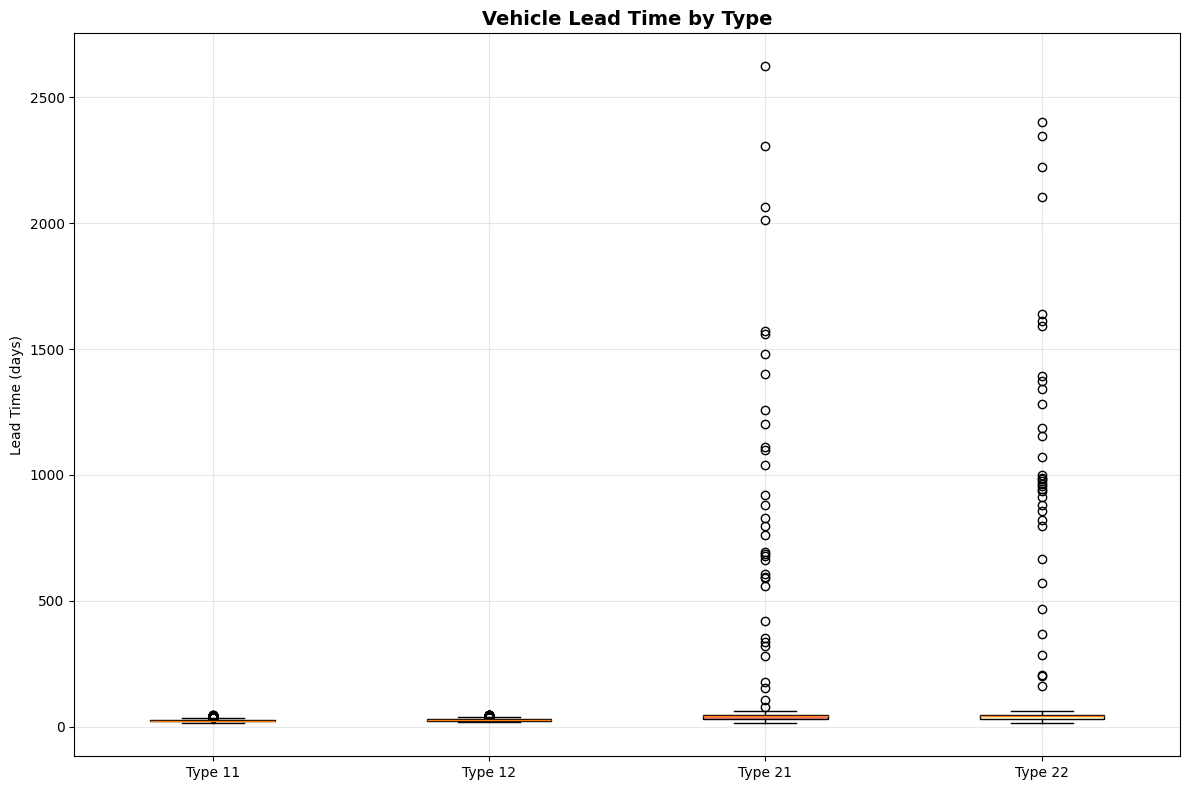


Analysis completed for types: 11, 12, 21, 22


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract vehicle type (11, 12, 21, 22)
final_dataset=pd.read_csv(r"Final_dataset_group_40.csv")
final_dataset['Vehicle_Type'] = final_dataset['Source_Table'].str.extract(r'Typ(\d+)')[0]

print("VEHICLE LEAD TIME ANALYSIS BY TYPE")
print("=" * 40)

# Calculate statistics for each type
stats_summary = []
vehicle_types = sorted(final_dataset['Vehicle_Type'].dropna().unique())

for vtype in vehicle_types:
    vtype_data = final_dataset[final_dataset['Vehicle_Type'] == vtype]
    lead_times = vtype_data['Days_Diff'].dropna()
    
    if len(lead_times) > 0:
        stats = {
            'Type': vtype,
            'Count': len(lead_times),
            'Min': lead_times.min(),
            'Max': lead_times.max(),
            'Mean': lead_times.mean(),
            'Median': lead_times.median(),
            'Std_Dev': lead_times.std()
        }
        stats_summary.append(stats)

# Summary table
if stats_summary:
    stats_df = pd.DataFrame(stats_summary)
    print("\nSUMMARY TABLE:")
    print(stats_df.round(1).to_string(index=False))
    
    # Boxplot for vehicle types
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    box_data = []
    box_labels = []
    
    for vtype in vehicle_types:
        vtype_data = final_dataset[final_dataset['Vehicle_Type'] == vtype]
        lead_times = vtype_data['Days_Diff'].dropna()
        if len(lead_times) > 0:
            box_data.append(lead_times)
            box_labels.append(f'Type {vtype}')
    
    if box_data:
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
        
        ax.set_title('Vehicle Lead Time by Type', fontsize=14, fontweight='bold')
        ax.set_ylabel('Lead Time (days)')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis completed for types: {', '.join(vehicle_types)}")
else:
    print("No lead time data available!")

### Components lead time analysis 

This part begins by defining the component lead time columns (`Karosserie_LeadTime`, `Schaltung_LeadTime`, `Sitze_LeadTime`, `Motor_LeadTime`) along with corresponding human-readable names. The script prints a header to indicate the start of component lead time analysis.

First, aggregated statistics are calculated across all vehicle types. For each component, the `dropna()` method is used to remove missing values, and key metrics are computed: count, minimum, maximum, mean, median, and standard deviation. Each component’s summary is stored in a dictionary and appended to a list for later tabular display.

The script then iterates over each vehicle type, filtering the dataset accordingly. For each type-component pair, lead times are extracted, cleaned, and summarized using the same statistical metrics. This generates a comprehensive summary table that includes both aggregated and type-specific statistics.

The summary is converted into a Pandas DataFrame and displayed in a readable format with values rounded to one decimal place. This provides an immediate overview of lead time distributions for each component, both in total and segmented by vehicle type.

For visualization, two sets of boxplots are created. The first plot aggregates all vehicle types to show component lead time distributions collectively. Non-missing lead times are collected into a list for plotting, and each box is assigned a distinct color. The plot includes titles, labels, rotated x-axis ticks, and a subtle grid for readability.

The second set of plots shows component lead times separately for each vehicle type. A 2×2 subplot grid is used, with each subplot corresponding to one vehicle type. For each subplot, the component lead times are collected, plotted, and styled with custom colors. Titles, axis labels, tick formatting, and grids are applied for clarity.

Finally, the script prints a completion message indicating the number of components and vehicle types analyzed. This workflow allows for both statistical inspection and visual comparison of component lead times across vehicle types.


COMPONENT LEAD TIME ANALYSIS

SUMMARY TABLE:
Vehicle_Type  Component  Count  Min  Max  Mean  Median  Std_Dev
         ALL Karosserie  32038    6   42  12.8    10.0      7.4
         ALL  Schaltung  32038    6   51  10.6     9.0      5.2
         ALL      Sitze  32038    6 2618  16.6    13.0     50.5
         ALL      Motor  32038    6   46  15.7    14.0      8.0
          11 Karosserie  19771    6   15   9.4     9.0      1.3
          11  Schaltung  19771    6   17   9.2     9.0      1.5
          11      Sitze  19771    6   34  13.3    12.0      5.2
          11      Motor  19771    6   20  12.3    13.0      2.7
          12 Karosserie   4080    7   14   9.8    10.0      1.2
          12  Schaltung   4080    6   15   9.2     9.0      1.5
          12      Sitze   4080    6   34  13.4    12.0      5.3
          12      Motor   4080    7   20  12.3    13.0      2.6
          21 Karosserie   5123    6   42  23.3    23.0      9.7
          21  Schaltung   5123    6   51  14.5    11.0     

C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\2146580562.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_agg, labels=box_labels_agg, patch_artist=True)


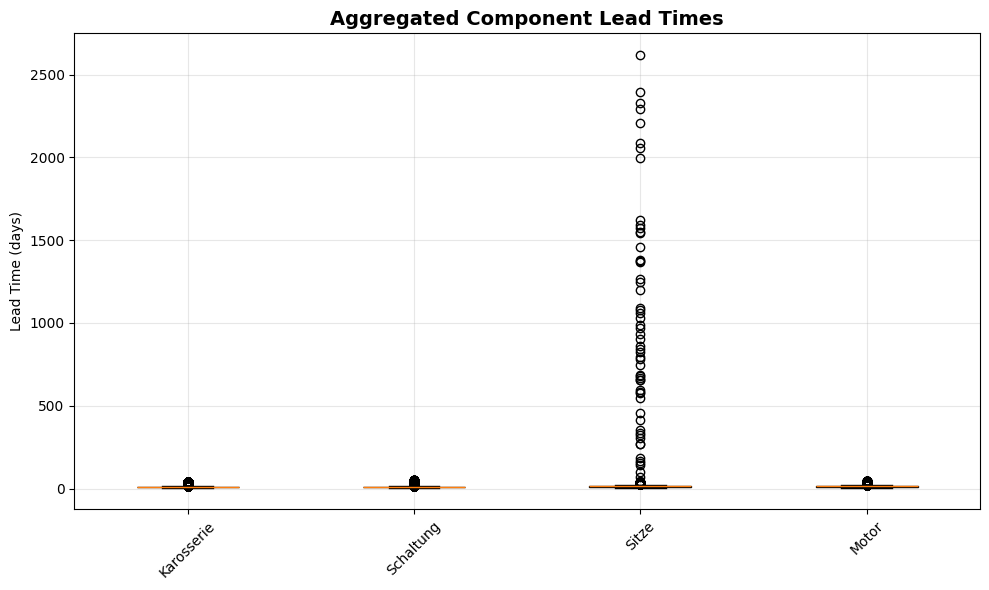

C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\2146580562.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_vtype, labels=box_labels_vtype, patch_artist=True)
C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\2146580562.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_vtype, labels=box_labels_vtype, patch_artist=True)
C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\2146580562.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_vtype, labels=box_labels_vtype, patch_artist=True)
C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\21

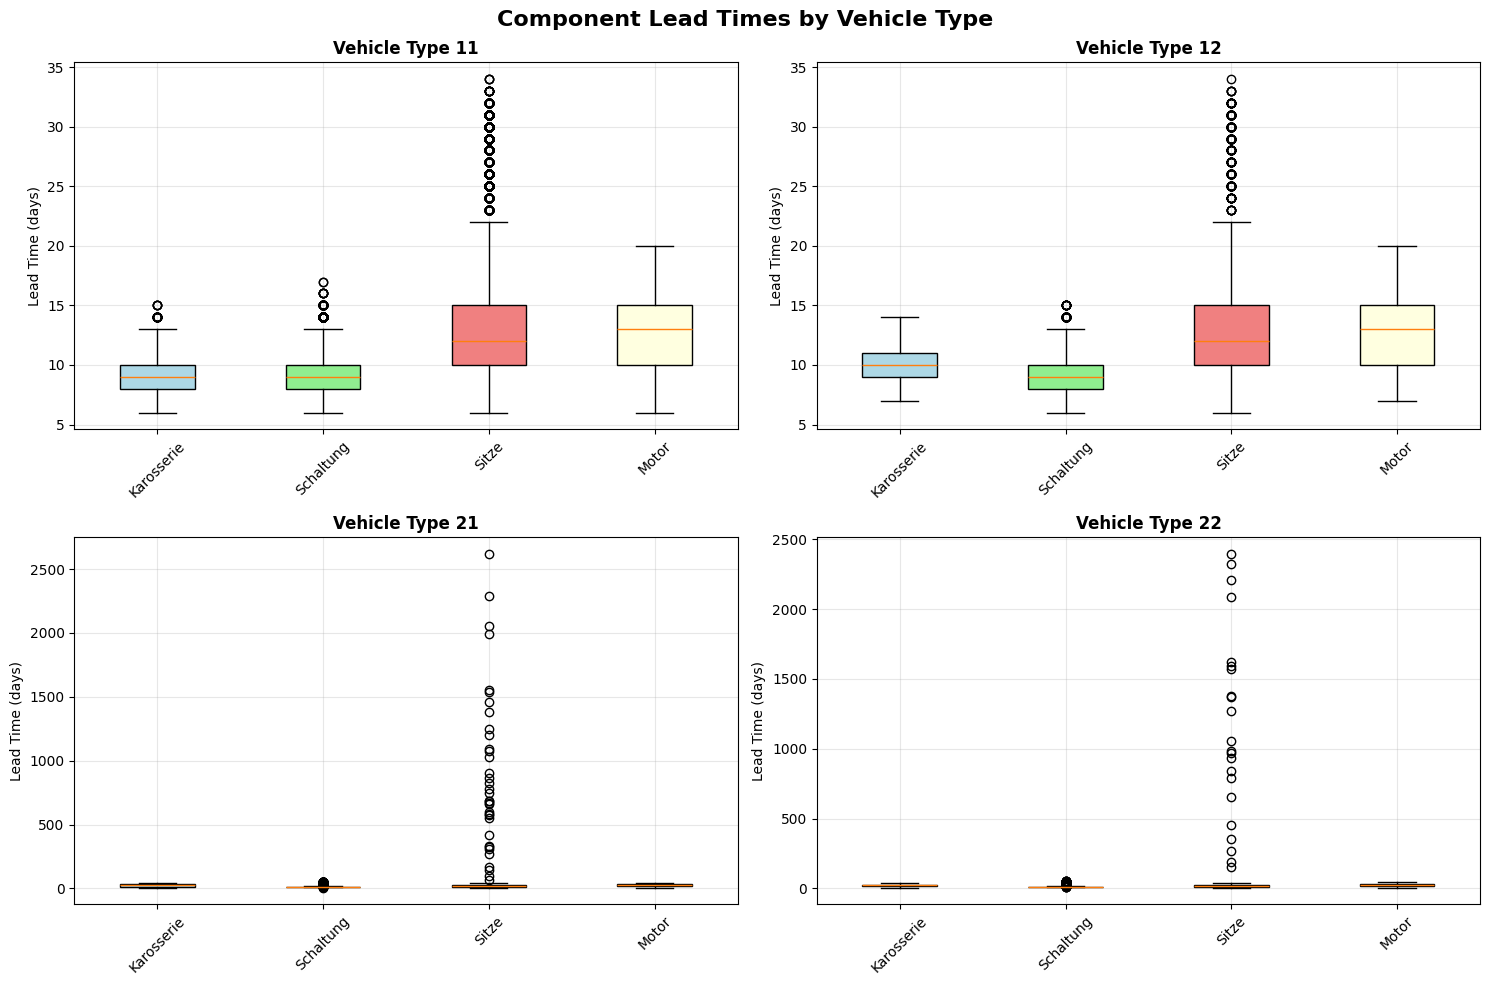

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Component lead time columns
component_cols = ['Karosserie_LeadTime', 'Schaltung_LeadTime', 'Sitze_LeadTime', 'Motor_LeadTime']
component_names = ['Karosserie', 'Schaltung', 'Sitze', 'Motor']

print("COMPONENT LEAD TIME ANALYSIS")
print("=" * 40)

# Calculate all statistics for summary table
vehicle_types = sorted(final_dataset['Vehicle_Type'].dropna().unique())
all_stats = []

# Aggregated statistics
for i, col in enumerate(component_cols):
    component_name = component_names[i]
    lead_times = final_dataset[col].dropna()
    
    if len(lead_times) > 0:
        stats = {
            'Vehicle_Type': 'ALL',
            'Component': component_name,
            'Count': len(lead_times),
            'Min': lead_times.min(),
            'Max': lead_times.max(),
            'Mean': lead_times.mean(),
            'Median': lead_times.median(),
            'Std_Dev': lead_times.std()
        }
        all_stats.append(stats)

# Statistics by vehicle type
for vtype in vehicle_types:
    vtype_data = final_dataset[final_dataset['Vehicle_Type'] == vtype]
    
    for i, col in enumerate(component_cols):
        component_name = component_names[i]
        lead_times = vtype_data[col].dropna()
        
        if len(lead_times) > 0:
            stats = {
                'Vehicle_Type': vtype,
                'Component': component_name,
                'Count': len(lead_times),
                'Min': lead_times.min(),
                'Max': lead_times.max(),
                'Mean': lead_times.mean(),
                'Median': lead_times.median(),
                'Std_Dev': lead_times.std()
            }
            all_stats.append(stats)

# Create and display summary table
if all_stats:
    summary_df = pd.DataFrame(all_stats)
    print("\nSUMMARY TABLE:")
    print(summary_df.round(1).to_string(index=False))

# 1. AGGREGATED PLOT
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

box_data_agg = []
box_labels_agg = []

for col in component_cols:
    lead_times = final_dataset[col].dropna()
    if len(lead_times) > 0:
        box_data_agg.append(lead_times)
        box_labels_agg.append(col.replace('_LeadTime', ''))

if box_data_agg:
    bp = ax.boxplot(box_data_agg, labels=box_labels_agg, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title('Aggregated Component Lead Times', fontsize=14, fontweight='bold')
    ax.set_ylabel('Lead Time (days)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. BY VEHICLE TYPE PLOTS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Component Lead Times by Vehicle Type', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, vtype in enumerate(vehicle_types):
    ax = axes[idx]
    vtype_data = final_dataset[final_dataset['Vehicle_Type'] == vtype]
    
    box_data_vtype = []
    box_labels_vtype = []
    
    for col in component_cols:
        lead_times = vtype_data[col].dropna()
        if len(lead_times) > 0:
            box_data_vtype.append(lead_times)
            box_labels_vtype.append(col.replace('_LeadTime', ''))
    
    if box_data_vtype:
        bp = ax.boxplot(box_data_vtype, labels=box_labels_vtype, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
        
        ax.set_title(f'Vehicle Type {vtype}', fontweight='bold')
        ax.set_ylabel('Lead Time (days)')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Visualization without outliers

The script performs **outlier detection and visualization** for both vehicle and component lead times using the IQR (Interquartile Range) method. A helper function `detect_outliers_iqr(data, multiplier=1.5)` is defined, which removes missing values, calculates the first and third quartiles (Q1, Q3), computes the IQR, and identifies outliers lying beyond `Q1 - 1.5*IQR` and `Q3 + 1.5*IQR`. It returns the cleaned data, count of outliers, and a boolean mask for outlier positions.

The workflow starts with **vehicle lead time analysis**. Vehicle types are extracted from the dataset, and for each type, lead times are filtered, cleaned using the IQR method, and summarized. Key metrics such as total count, outliers count, percentage of outliers, clean data count, and min/max values before and after cleaning are stored in a structured dictionary and later converted to a summary DataFrame. A boxplot is generated to visualize the cleaned lead times per vehicle type, using distinct colors for clarity.

Next, **component lead time outlier analysis** is conducted. Both aggregated statistics across all vehicles and type-specific statistics are computed. For each component, outliers are identified using the same IQR-based function, and cleaned lead times are stored separately. The results are compiled into a detailed summary table with counts, outliers, percentages, and min/max values before and after cleaning.

Visualization is performed in two stages. The first plot aggregates all vehicle types to show component lead times collectively, while the second creates a 2×2 subplot grid to display component lead times by vehicle type. For both, the boxplots are color-coded, axes labeled, grids enabled, and titles formatted for readability.

Finally, the script provides a **summary of outlier impact**, reporting the total number of vehicle and component records, the number of outliers removed, and the corresponding percentages. This step quantifies how many records were affected by outlier removal, ensuring transparency for downstream analysis.

Overall, the workflow ensures robust outlier handling and produces clear visualizations for lead time distributions, enabling better comparison and analysis across vehicle types and components.


OUTLIER ANALYSIS AND VISUALIZATION WITHOUT OUTLIERS

1. VEHICLE LEAD TIME OUTLIER ANALYSIS
----------------------------------------

VEHICLE OUTLIER SUMMARY:
Vehicle_Type  Total_Count  Outliers_Count  Outliers_Percentage  Clean_Count  Original_Min  Original_Max  Clean_Min  Clean_Max
          11        19771            1119                 5.66        18652            13            45         13         36
          12         4080             313                 7.67         3767            17            45         17         38
          21         5123              35                 0.68         5088            15          2624         15         61
          22         3064              35                 1.14         3029            14          2401         14         63


C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\3584634496.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_clean, labels=box_labels, patch_artist=True)


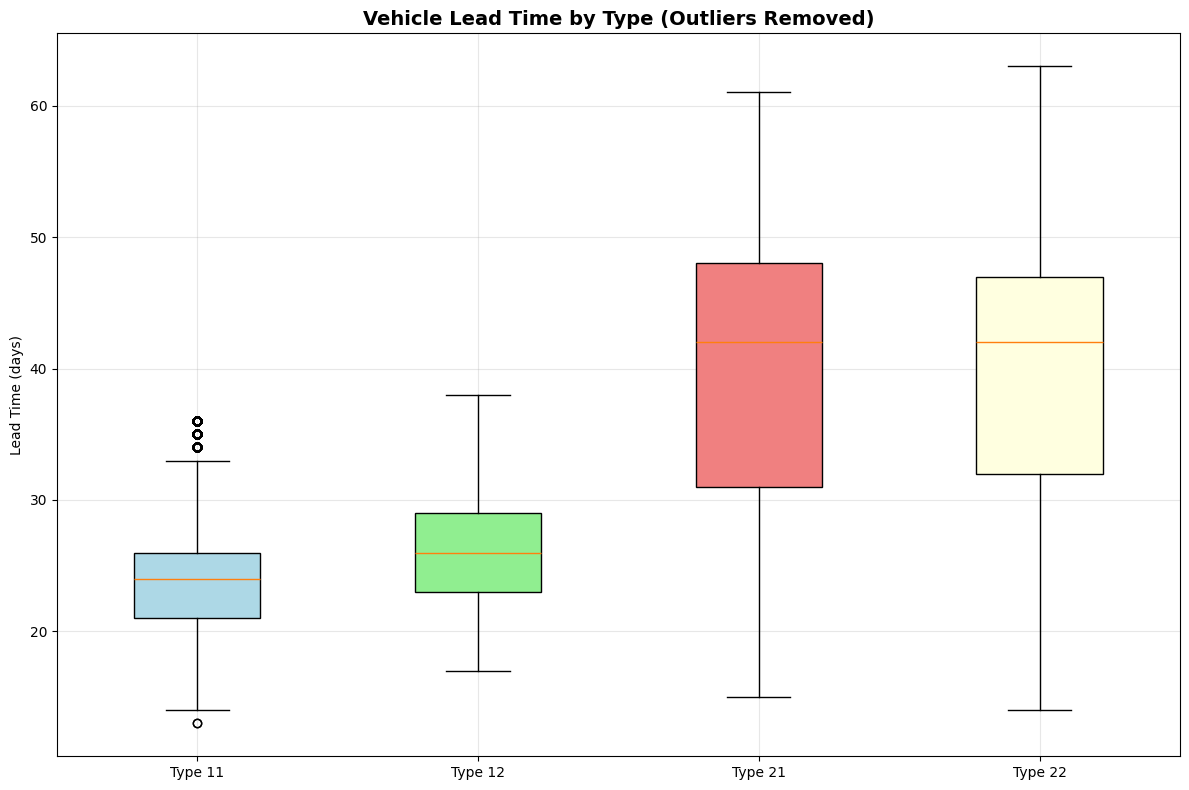


2. COMPONENT LEAD TIME OUTLIER ANALYSIS
----------------------------------------

COMPONENT OUTLIER SUMMARY:
 Component Vehicle_Type  Total_Count  Outliers_Count  Outliers_Percentage  Clean_Count  Original_Min  Original_Max  Clean_Min  Clean_Max
Karosserie          ALL        32038            5610                17.51        26428             6            42          6         16
 Schaltung          ALL        32038            1349                 4.21        30689             6            51          6         15
     Sitze          ALL        32038            3701                11.55        28337             6          2618          6         25
     Motor          ALL        32038            4507                14.07        27531             6            46          6         23
Karosserie           11        19771              39                 0.20        19732             6            15          6         13
 Schaltung           11        19771             337                

C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\3584634496.py:183: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_clean_agg, labels=box_labels_agg, patch_artist=True)


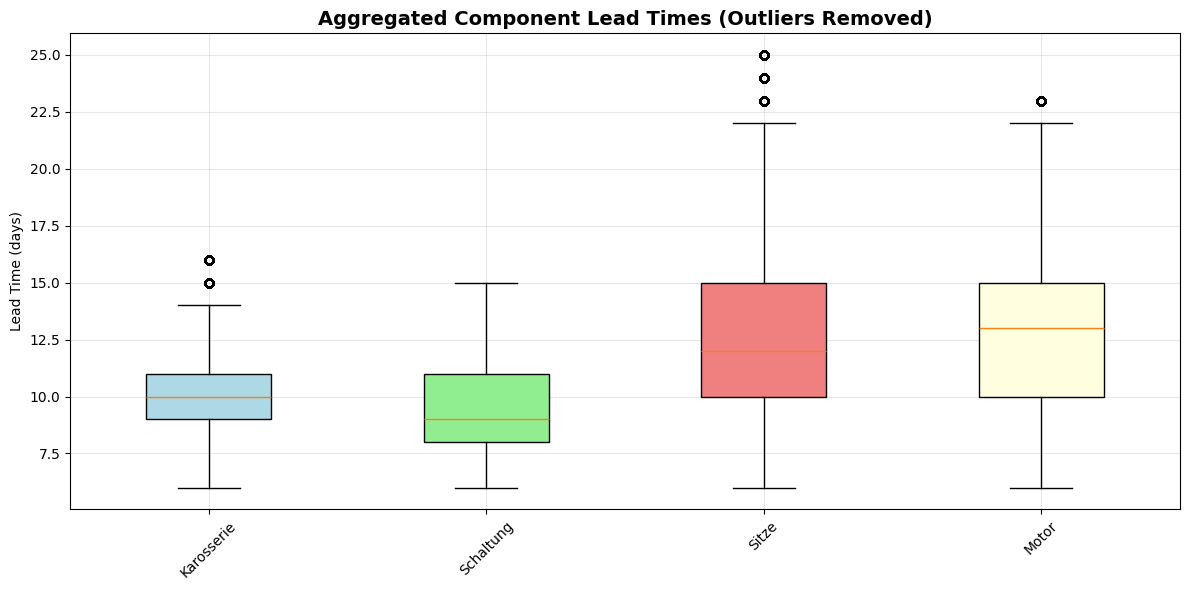

C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\3584634496.py:216: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_clean_vtype, labels=box_labels_vtype, patch_artist=True)
C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\3584634496.py:216: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_clean_vtype, labels=box_labels_vtype, patch_artist=True)
C:\Users\kraie\AppData\Local\Temp\ipykernel_25220\3584634496.py:216: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data_clean_vtype, labels=box_labels_vtype, patch_artist=True)
C:\Users\kraie\AppData\Local\Temp\

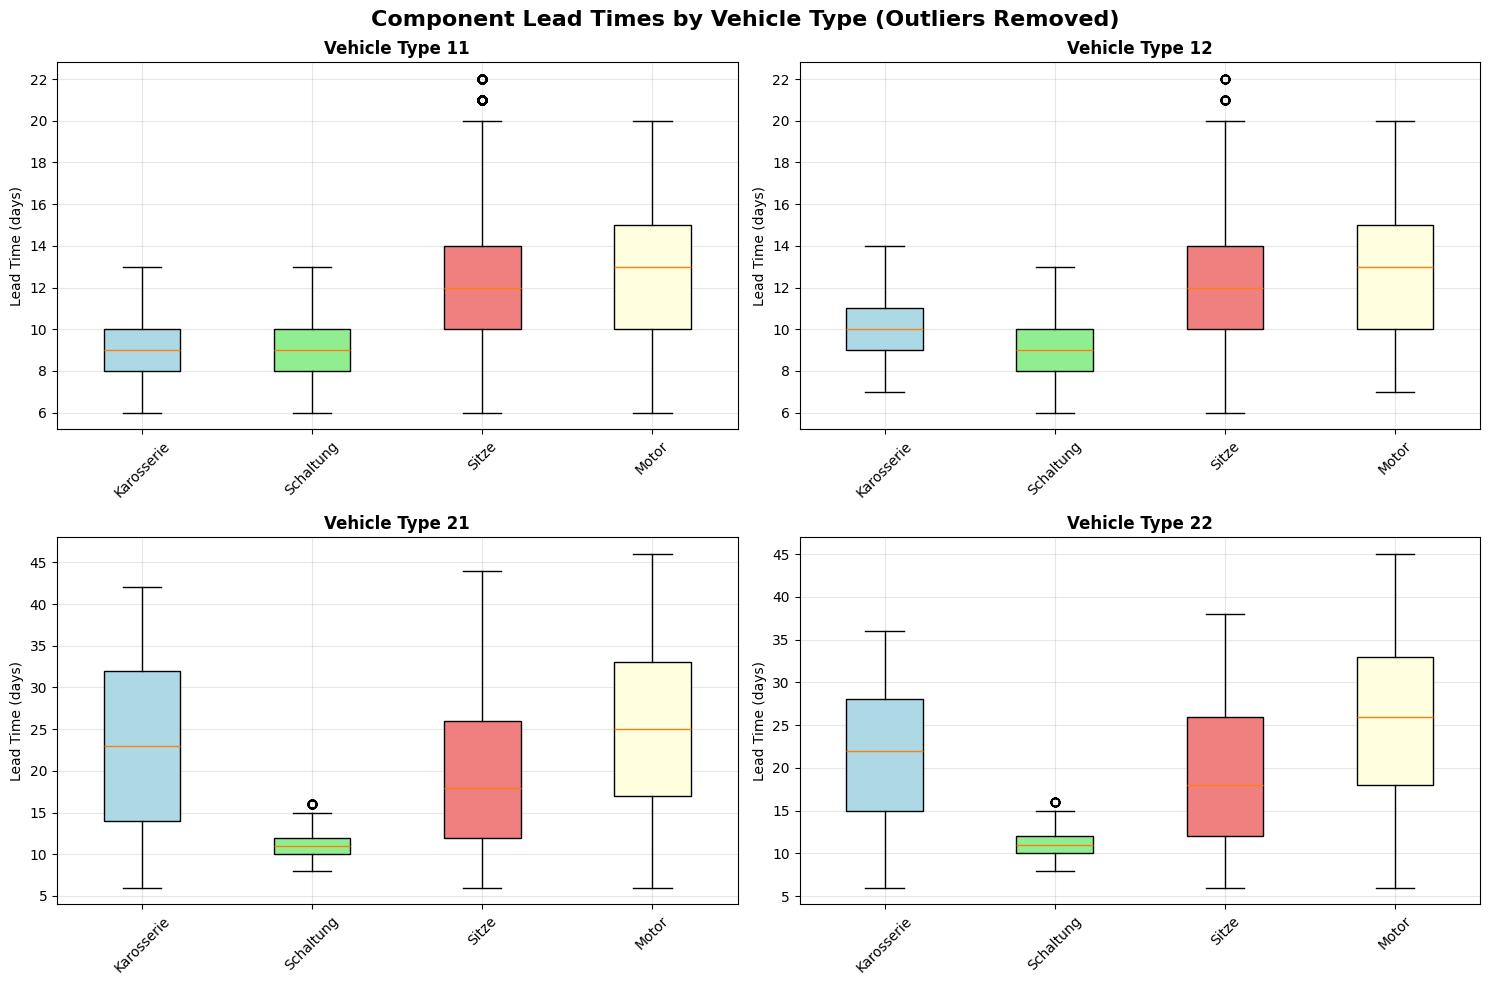


4. SUMMARY OF OUTLIER IMPACT
----------------------------------------
VEHICLE ANALYSIS:
  - Total vehicle records: 32,038
  - Total outliers removed: 1,502
  - Outlier percentage: 4.69%

COMPONENT ANALYSIS:
  - Total component records: 256,304
  - Total outliers removed: 18,844
  - Outlier percentage: 7.35%

Analysis completed! All visualizations show data without outliers using IQR method (1.5x IQR rule).


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def detect_outliers_iqr(data, multiplier=1.5):
    """
    Detect outliers using IQR method
    Returns: (clean_data, outliers_count, outliers_mask)
    """
    data_clean = data.dropna()
    if len(data_clean) == 0:
        return data_clean, 0, pd.Series(dtype=bool)
    
    Q1 = data_clean.quantile(0.25)
    Q3 = data_clean.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers_mask = (data_clean < lower_bound) | (data_clean > upper_bound)
    clean_data = data_clean[~outliers_mask]
    outliers_count = outliers_mask.sum()
    
    return clean_data, outliers_count, outliers_mask

print("OUTLIER ANALYSIS AND VISUALIZATION WITHOUT OUTLIERS")
print("=" * 60)

# =============================================================================
# 1. VEHICLE LEAD TIME ANALYSIS WITHOUT OUTLIERS
# =============================================================================

print("\n1. VEHICLE LEAD TIME OUTLIER ANALYSIS")
print("-" * 40)

vehicle_types = sorted(final_dataset['Vehicle_Type'].dropna().unique())
vehicle_outlier_summary = []
vehicle_clean_data = {}

for vtype in vehicle_types:
    vtype_data = final_dataset[final_dataset['Vehicle_Type'] == vtype]
    lead_times = vtype_data['Days_Diff'].dropna()
    
    if len(lead_times) > 0:
        clean_data, outliers_count, outliers_mask = detect_outliers_iqr(lead_times)
        
        vehicle_clean_data[vtype] = clean_data
        
        outlier_info = {
            'Vehicle_Type': vtype,
            'Total_Count': len(lead_times),
            'Outliers_Count': outliers_count,
            'Outliers_Percentage': (outliers_count / len(lead_times)) * 100,
            'Clean_Count': len(clean_data),
            'Original_Min': lead_times.min(),
            'Original_Max': lead_times.max(),
            'Clean_Min': clean_data.min() if len(clean_data) > 0 else None,
            'Clean_Max': clean_data.max() if len(clean_data) > 0 else None
        }
        vehicle_outlier_summary.append(outlier_info)

# Display vehicle outlier summary
if vehicle_outlier_summary:
    outlier_df = pd.DataFrame(vehicle_outlier_summary)
    print("\nVEHICLE OUTLIER SUMMARY:")
    print(outlier_df.round(2).to_string(index=False))

# Plot vehicle lead times without outliers
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Clean data without outliers
box_data_clean = []
box_labels = []
for vtype in vehicle_types:
    if vtype in vehicle_clean_data and len(vehicle_clean_data[vtype]) > 0:
        box_data_clean.append(vehicle_clean_data[vtype])
        box_labels.append(f'Type {vtype}')

if box_data_clean:
    bp = ax.boxplot(box_data_clean, labels=box_labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    
    ax.set_title('Vehicle Lead Time by Type (Outliers Removed)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Lead Time (days)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 2. COMPONENT LEAD TIME ANALYSIS WITHOUT OUTLIERS
# =============================================================================

print("\n2. COMPONENT LEAD TIME OUTLIER ANALYSIS")
print("-" * 40)

component_cols = ['Karosserie_LeadTime', 'Schaltung_LeadTime', 'Sitze_LeadTime', 'Motor_LeadTime']
component_names = ['Karosserie', 'Schaltung', 'Sitze', 'Motor']

# Component outlier analysis - AGGREGATED
component_outlier_summary = []
component_clean_data = {}

for i, col in enumerate(component_cols):
    component_name = component_names[i]
    lead_times = final_dataset[col].dropna()
    
    if len(lead_times) > 0:
        clean_data, outliers_count, outliers_mask = detect_outliers_iqr(lead_times)
        
        component_clean_data[col] = clean_data
        
        outlier_info = {
            'Component': component_name,
            'Vehicle_Type': 'ALL',
            'Total_Count': len(lead_times),
            'Outliers_Count': outliers_count,
            'Outliers_Percentage': (outliers_count / len(lead_times)) * 100,
            'Clean_Count': len(clean_data),
            'Original_Min': lead_times.min(),
            'Original_Max': lead_times.max(),
            'Clean_Min': clean_data.min() if len(clean_data) > 0 else None,
            'Clean_Max': clean_data.max() if len(clean_data) > 0 else None
        }
        component_outlier_summary.append(outlier_info)

# Component outlier analysis - BY VEHICLE TYPE
component_clean_data_by_type = {}

for vtype in vehicle_types:
    vtype_data = final_dataset[final_dataset['Vehicle_Type'] == vtype]
    component_clean_data_by_type[vtype] = {}
    
    for i, col in enumerate(component_cols):
        component_name = component_names[i]
        lead_times = vtype_data[col].dropna()
        
        if len(lead_times) > 0:
            clean_data, outliers_count, outliers_mask = detect_outliers_iqr(lead_times)
            
            component_clean_data_by_type[vtype][col] = clean_data
            
            outlier_info = {
                'Component': component_name,
                'Vehicle_Type': vtype,
                'Total_Count': len(lead_times),
                'Outliers_Count': outliers_count,
                'Outliers_Percentage': (outliers_count / len(lead_times)) * 100,
                'Clean_Count': len(clean_data),
                'Original_Min': lead_times.min(),
                'Original_Max': lead_times.max(),
                'Clean_Min': clean_data.min() if len(clean_data) > 0 else None,
                'Clean_Max': clean_data.max() if len(clean_data) > 0 else None
            }
            component_outlier_summary.append(outlier_info)

# Display component outlier summary
if component_outlier_summary:
    comp_outlier_df = pd.DataFrame(component_outlier_summary)
    print("\nCOMPONENT OUTLIER SUMMARY:")
    print(comp_outlier_df.round(2).to_string(index=False))

# =============================================================================
# 3. COMPONENT PLOTS WITHOUT OUTLIERS
# =============================================================================

# 3A. AGGREGATED COMPONENT PLOT
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Clean aggregated data without outliers
box_data_clean_agg = []
box_labels_agg = []

for col in component_cols:
    if col in component_clean_data and len(component_clean_data[col]) > 0:
        box_data_clean_agg.append(component_clean_data[col])
        box_labels_agg.append(col.replace('_LeadTime', ''))

if box_data_clean_agg:
    bp = ax.boxplot(box_data_clean_agg, labels=box_labels_agg, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title('Aggregated Component Lead Times (Outliers Removed)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Lead Time (days)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3B. COMPONENT PLOTS BY VEHICLE TYPE
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Component Lead Times by Vehicle Type (Outliers Removed)', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, vtype in enumerate(vehicle_types):
    ax = axes[idx]
    
    box_data_clean_vtype = []
    box_labels_vtype = []
    
    for col in component_cols:
        if vtype in component_clean_data_by_type and col in component_clean_data_by_type[vtype]:
            clean_data = component_clean_data_by_type[vtype][col]
            if len(clean_data) > 0:
                box_data_clean_vtype.append(clean_data)
                box_labels_vtype.append(col.replace('_LeadTime', ''))
    
    if box_data_clean_vtype:
        bp = ax.boxplot(box_data_clean_vtype, labels=box_labels_vtype, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
        
        ax.set_title(f'Vehicle Type {vtype}', fontweight='bold')
        ax.set_ylabel('Lead Time (days)')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. SUMMARY STATISTICS
# =============================================================================

print("\n4. SUMMARY OF OUTLIER IMPACT")
print("-" * 40)

total_vehicle_outliers = sum([info['Outliers_Count'] for info in vehicle_outlier_summary])
total_vehicle_records = sum([info['Total_Count'] for info in vehicle_outlier_summary])

total_component_outliers = sum([info['Outliers_Count'] for info in component_outlier_summary])
total_component_records = sum([info['Total_Count'] for info in component_outlier_summary])

print(f"VEHICLE ANALYSIS:")
print(f"  - Total vehicle records: {total_vehicle_records:,}")
print(f"  - Total outliers removed: {total_vehicle_outliers:,}")
print(f"  - Outlier percentage: {(total_vehicle_outliers/total_vehicle_records)*100:.2f}%")

print(f"\nCOMPONENT ANALYSIS:")
print(f"  - Total component records: {total_component_records:,}")
print(f"  - Total outliers removed: {total_component_outliers:,}")
print(f"  - Outlier percentage: {(total_component_outliers/total_component_records)*100:.2f}%")

print(f"\nAnalysis completed! All visualizations show data without outliers using IQR method (1.5x IQR rule).")

### Vehicle Production Trend Analysis

Analyzing production trends over time for vehicles only

The script performs a **comprehensive analysis of vehicle production trends** over time, both overall and by vehicle type, using time series and statistical methods. It leverages `pandas` for data manipulation, `matplotlib` and `seaborn` for visualization, and `numpy` for numeric operations.

The workflow starts by **preparing the dataset**. The production date column (`Vehicle_Prod_Date`) is converted to `datetime`, and missing values in date or vehicle type are removed. Additional time-based columns are extracted, including `Year`, `Month`, `Quarter`, `Year_Month` (period), and `Year_Quarter` (period), which enable aggregation and trend analysis at multiple temporal levels.

**Overall production analysis** computes yearly, quarterly, and monthly statistics. Aggregated metrics include the total count of vehicles per period, descriptive statistics (mean, std, min, max), and summary tables for quick inspection. This step provides a clear picture of production volumes over time.

**Production trend visualizations** include multiple plots: monthly line trends, yearly bar comparisons, quarterly heatmaps using `seaborn`, and monthly distribution histograms to visualize seasonality. Value labels, grids, and color coding enhance interpretability and allow for immediate visual insights into production patterns.

**Vehicle-type-specific analysis** repeats the aggregation for each vehicle type. Total production, date ranges, average monthly production, and peak/low months are computed per type. Comparative visualizations are generated in a 2×2 subplot grid showing monthly trends, yearly totals, market share over time (percentage area plots), and monthly seasonality per vehicle type. Colors are consistently assigned for clarity across plots.

**Production efficiency metrics** are calculated to assess operational stability. The coefficient of variation (CV) measures consistency in monthly production, with lower CV indicating more stable output. Year-over-year growth rates quantify trends in production levels, identifying growing, stable, or declining types. These metrics are combined into a summary table that includes total production, number of months, average, peak, and minimum monthly production, CV, and growth rates.

Overall, this workflow provides a **data-driven understanding of production volumes, seasonality, and efficiency**, allowing for informed insights into trends across vehicle types and over time.


VEHICLE PRODUCTION TREND ANALYSIS
Data range: 2008-11-20 00:00:00 to 2016-11-26 00:00:00
Total vehicles analyzed: 32,038
Vehicle types: ['11', '12', '21', '22']

1. OVERALL PRODUCTION STATISTICS
------------------------------

Yearly Production:
 Year  Count
 2008    417
 2009   3934
 2010   3993
 2011   4023
 2012   4092
 2013   3967
 2014   3975
 2015   4005
 2016   3632

Quarterly Production (showing last 10 quarters):
Year_Quarter  Count
      2014Q3   1027
      2014Q4   1010
      2015Q1    989
      2015Q2    993
      2015Q3   1026
      2015Q4    997
      2016Q1   1005
      2016Q2   1021
      2016Q3   1032
      2016Q4    574

Monthly Production Statistics:
Average monthly production: 330.3 vehicles
Std deviation: 34.8
Min monthly production: 80
Max monthly production: 377


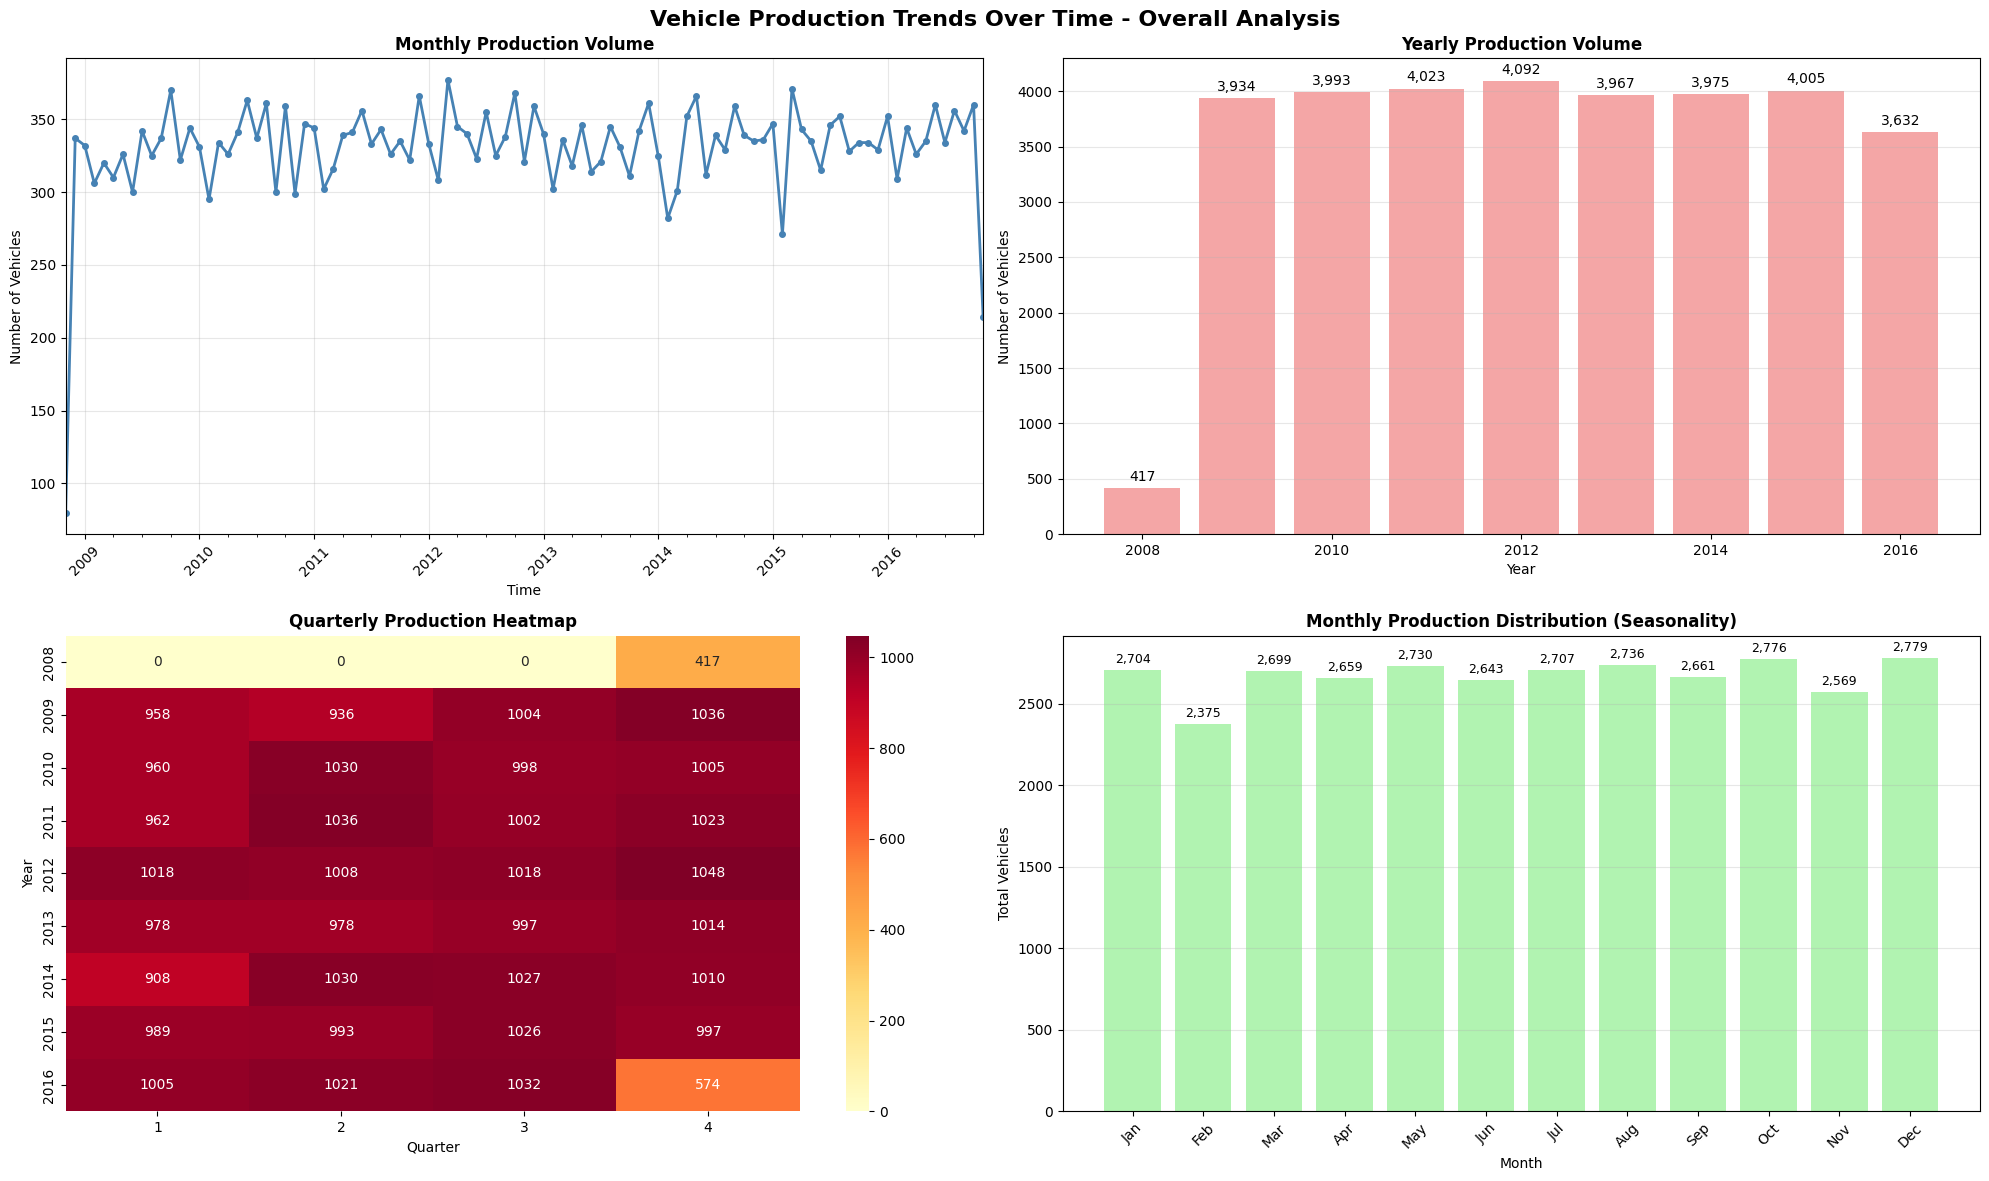


2. PRODUCTION ANALYSIS BY VEHICLE TYPE
----------------------------------------

Vehicle Type 11:
  Total production: 19,771 vehicles
  Date range: 2008-11-20 00:00:00 to 2016-11-26 00:00:00
  Average monthly: 203.8 vehicles
  Peak month: 249 vehicles (2013-12)
  Low month: 59 vehicles (2008-11)

Vehicle Type 12:
  Total production: 4,080 vehicles
  Date range: 2008-11-25 00:00:00 to 2016-11-24 00:00:00
  Average monthly: 42.1 vehicles
  Peak month: 60 vehicles (2012-04)
  Low month: 5 vehicles (2008-11)

Vehicle Type 21:
  Total production: 5,123 vehicles
  Date range: 2008-11-22 00:00:00 to 2016-11-20 00:00:00
  Average monthly: 52.8 vehicles
  Peak month: 69 vehicles (2011-12)
  Low month: 11 vehicles (2008-11)

Vehicle Type 22:
  Total production: 3,064 vehicles
  Date range: 2008-11-21 00:00:00 to 2016-11-18 00:00:00
  Average monthly: 31.6 vehicles
  Peak month: 44 vehicles (2011-10)
  Low month: 5 vehicles (2008-11)


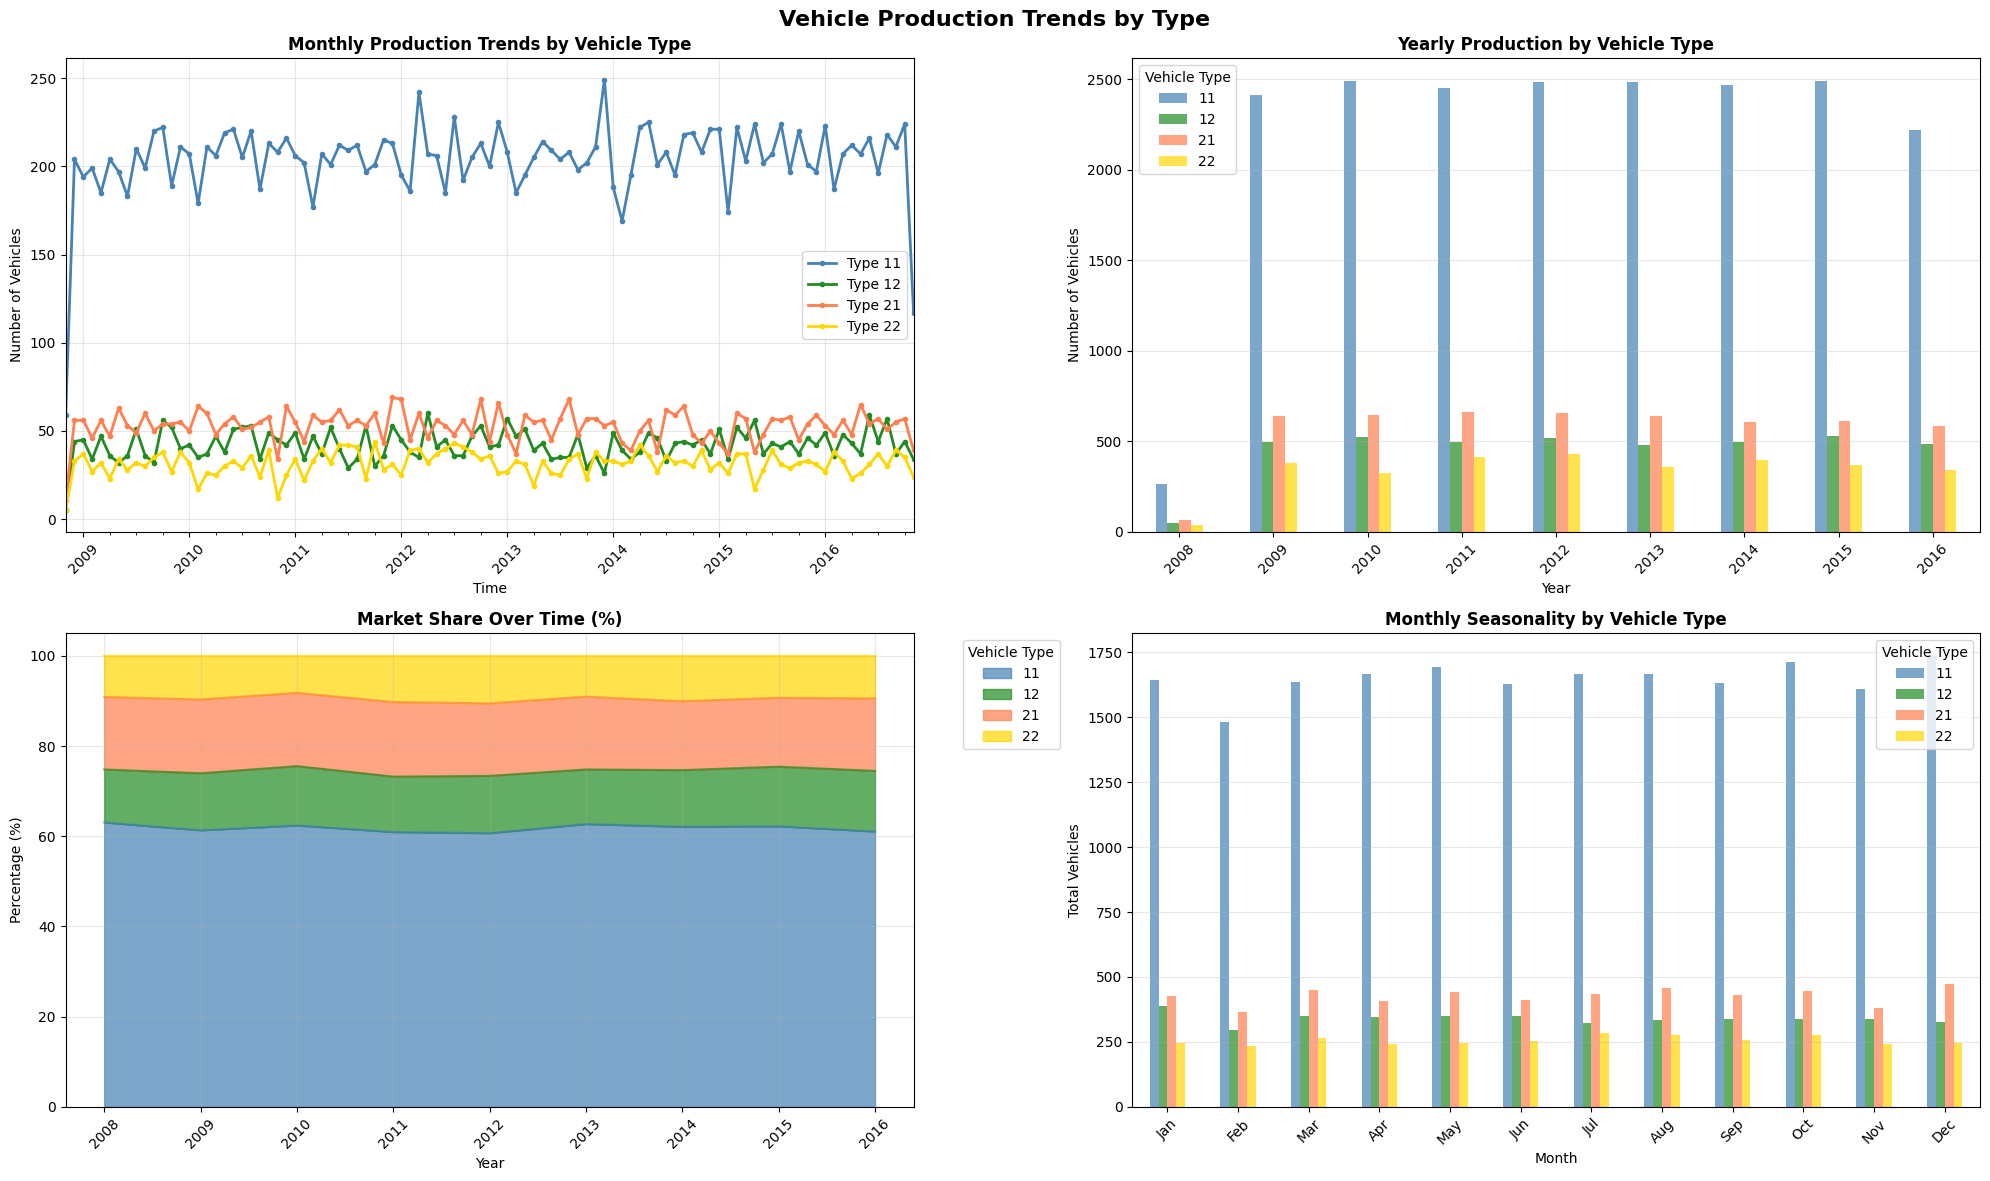


3. PRODUCTION EFFICIENCY METRICS
-----------------------------------
Production Consistency (Lower CV = More Consistent):
  Type 11: CV = 10.9% (High consistency)
  Type 12: CV = 20.1% (High consistency)
  Type 21: CV = 16.4% (High consistency)
  Type 22: CV = 21.7% (High consistency)

Production Growth Rates (First vs Last Year):
  Type 11: +743.3% (Growing)
  Type 12: +895.9% (Growing)
  Type 21: +770.1% (Growing)
  Type 22: +802.6% (Growing)

PRODUCTION SUMMARY TABLE:
Vehicle_Type  Total_Production  Production_Months  Avg_Monthly  Peak_Monthly  Min_Monthly  Consistency_CV  Growth_Rate
          11             19771                 97        203.8           249           59            10.9        743.3
          12              4080                 97         42.1            60            5            20.1        895.9
          21              5123                 97         52.8            69           11            16.4        770.1
          22              3064                 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

print("VEHICLE PRODUCTION TREND ANALYSIS")
print("=" * 50)

# Prepare data for time series analysis
df_time = final_dataset.copy()
df_time['Vehicle_Prod_Date'] = pd.to_datetime(df_time['Vehicle_Prod_Date'])
df_time = df_time.dropna(subset=['Vehicle_Prod_Date', 'Vehicle_Type'])

# Extract time components for analysis
df_time['Year'] = df_time['Vehicle_Prod_Date'].dt.year
df_time['Month'] = df_time['Vehicle_Prod_Date'].dt.month
df_time['Quarter'] = df_time['Vehicle_Prod_Date'].dt.quarter
df_time['Year_Month'] = df_time['Vehicle_Prod_Date'].dt.to_period('M')
df_time['Year_Quarter'] = df_time['Vehicle_Prod_Date'].dt.to_period('Q')

print(f"Data range: {df_time['Vehicle_Prod_Date'].min()} to {df_time['Vehicle_Prod_Date'].max()}")
print(f"Total vehicles analyzed: {len(df_time):,}")
print(f"Vehicle types: {sorted(df_time['Vehicle_Type'].unique())}")

# =============================================================================
# 1. OVERALL PRODUCTION ANALYSIS
# =============================================================================

print("\n1. OVERALL PRODUCTION STATISTICS")
print("-" * 30)

# Production by year
yearly_production = df_time.groupby('Year').size().reset_index(name='Count')
print("\nYearly Production:")
print(yearly_production.to_string(index=False))

# Production by quarter
quarterly_production = df_time.groupby('Year_Quarter').size().reset_index(name='Count')
print(f"\nQuarterly Production (showing last 10 quarters):")
print(quarterly_production.tail(10).to_string(index=False))

# Monthly statistics
monthly_stats = df_time.groupby('Year_Month').size().describe()
print(f"\nMonthly Production Statistics:")
print(f"Average monthly production: {monthly_stats['mean']:.1f} vehicles")
print(f"Std deviation: {monthly_stats['std']:.1f}")
print(f"Min monthly production: {monthly_stats['min']:.0f}")
print(f"Max monthly production: {monthly_stats['max']:.0f}")

# =============================================================================
# 2. PRODUCTION TREND VISUALIZATIONS - OVERALL
# =============================================================================

# Create comprehensive production trend plots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Vehicle Production Trends Over Time - Overall Analysis', fontsize=16, fontweight='bold')

# 2A. Monthly Production Trend
ax1 = axes[0, 0]
monthly_data = df_time.groupby('Year_Month').size()
monthly_data.plot(kind='line', ax=ax1, color='steelblue', linewidth=2, marker='o', markersize=4)
ax1.set_title('Monthly Production Volume', fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Vehicles')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2B. Yearly Production Comparison
ax2 = axes[0, 1]
yearly_data = df_time.groupby('Year').size()
bars = ax2.bar(yearly_data.index, yearly_data.values, color='lightcoral', alpha=0.7)
ax2.set_title('Yearly Production Volume', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Vehicles')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# 2C. Quarterly Production Heatmap
ax3 = axes[1, 0]
quarterly_pivot = df_time.groupby(['Year', 'Quarter']).size().unstack(fill_value=0)
if not quarterly_pivot.empty:
    sns.heatmap(quarterly_pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax3)
    ax3.set_title('Quarterly Production Heatmap', fontweight='bold')
    ax3.set_xlabel('Quarter')
    ax3.set_ylabel('Year')

# 2D. Monthly Distribution (Seasonality)
ax4 = axes[1, 1]
monthly_dist = df_time.groupby('Month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bars = ax4.bar(range(1, 13), monthly_dist.values, color='lightgreen', alpha=0.7)
ax4.set_title('Monthly Production Distribution (Seasonality)', fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Total Vehicles')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_names, rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# 3. PRODUCTION ANALYSIS BY VEHICLE TYPE
# =============================================================================

print(f"\n2. PRODUCTION ANALYSIS BY VEHICLE TYPE")
print("-" * 40)

vehicle_types = sorted(df_time['Vehicle_Type'].unique())

# Production statistics by vehicle type
for vtype in vehicle_types:
    vtype_data = df_time[df_time['Vehicle_Type'] == vtype]
    print(f"\nVehicle Type {vtype}:")
    print(f"  Total production: {len(vtype_data):,} vehicles")
    print(f"  Date range: {vtype_data['Vehicle_Prod_Date'].min()} to {vtype_data['Vehicle_Prod_Date'].max()}")
    
    # Monthly stats for this type
    monthly_type = vtype_data.groupby('Year_Month').size()
    if len(monthly_type) > 0:
        print(f"  Average monthly: {monthly_type.mean():.1f} vehicles")
        print(f"  Peak month: {monthly_type.max():.0f} vehicles ({monthly_type.idxmax()})")
        print(f"  Low month: {monthly_type.min():.0f} vehicles ({monthly_type.idxmin()})")

# =============================================================================
# 4. COMPARATIVE TREND ANALYSIS BY VEHICLE TYPE
# =============================================================================

# Create vehicle type comparison plots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Vehicle Production Trends by Type', fontsize=16, fontweight='bold')

# 4A. Monthly Trends by Vehicle Type
ax1 = axes[0, 0]
colors = ['steelblue', 'forestgreen', 'coral', 'gold']
for i, vtype in enumerate(vehicle_types):
    vtype_monthly = df_time[df_time['Vehicle_Type'] == vtype].groupby('Year_Month').size()
    if len(vtype_monthly) > 0:
        vtype_monthly.plot(kind='line', ax=ax1, label=f'Type {vtype}', 
                          color=colors[i], linewidth=2, marker='o', markersize=3)

ax1.set_title('Monthly Production Trends by Vehicle Type', fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Vehicles')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 4B. Yearly Production by Type
ax2 = axes[0, 1]
yearly_by_type = df_time.groupby(['Year', 'Vehicle_Type']).size().unstack(fill_value=0)
yearly_by_type.plot(kind='bar', ax=ax2, color=colors[:len(vehicle_types)], alpha=0.7)
ax2.set_title('Yearly Production by Vehicle Type', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Vehicles')
ax2.legend(title='Vehicle Type')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# 4C. Market Share Over Time (Percentage)
ax3 = axes[1, 0]
yearly_pct = yearly_by_type.div(yearly_by_type.sum(axis=1), axis=0) * 100
yearly_pct.plot(kind='area', ax=ax3, color=colors[:len(vehicle_types)], alpha=0.7)
ax3.set_title('Market Share Over Time (%)', fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Percentage (%)')
ax3.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4D. Monthly Seasonality by Type
ax4 = axes[1, 1]
monthly_by_type = df_time.groupby(['Month', 'Vehicle_Type']).size().unstack(fill_value=0)
monthly_by_type.plot(kind='bar', ax=ax4, color=colors[:len(vehicle_types)], alpha=0.7)
ax4.set_title('Monthly Seasonality by Vehicle Type', fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Total Vehicles')
ax4.legend(title='Vehicle Type')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_xticks(range(12))
ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 5. PRODUCTION EFFICIENCY METRICS
# =============================================================================

print(f"\n3. PRODUCTION EFFICIENCY METRICS")
print("-" * 35)

# Calculate production consistency (coefficient of variation)
production_consistency = {}
growth_rates = {}

for vtype in vehicle_types:
    vtype_monthly = df_time[df_time['Vehicle_Type'] == vtype].groupby('Year_Month').size()
    if len(vtype_monthly) > 1:
        cv = (vtype_monthly.std() / vtype_monthly.mean()) * 100
        production_consistency[vtype] = cv
        
        # Calculate growth rate (comparing first and last year)
        yearly_type = df_time[df_time['Vehicle_Type'] == vtype].groupby('Year').size()
        if len(yearly_type) > 1:
            first_year = yearly_type.iloc[0]
            last_year = yearly_type.iloc[-1]
            growth_rate = ((last_year - first_year) / first_year) * 100
            growth_rates[vtype] = growth_rate

print("Production Consistency (Lower CV = More Consistent):")
for vtype, cv in production_consistency.items():
    consistency_level = "High" if cv < 30 else "Medium" if cv < 50 else "Low"
    print(f"  Type {vtype}: CV = {cv:.1f}% ({consistency_level} consistency)")

if growth_rates:
    print(f"\nProduction Growth Rates (First vs Last Year):")
    for vtype, growth in growth_rates.items():
        trend = "Growing" if growth > 5 else "Declining" if growth < -5 else "Stable"
        print(f"  Type {vtype}: {growth:+.1f}% ({trend})")

# Summary statistics table
summary_stats = []
for vtype in vehicle_types:
    vtype_data = df_time[df_time['Vehicle_Type'] == vtype]
    vtype_monthly = vtype_data.groupby('Year_Month').size()
    
    stats = {
        'Vehicle_Type': vtype,
        'Total_Production': len(vtype_data),
        'Production_Months': len(vtype_monthly),
        'Avg_Monthly': vtype_monthly.mean() if len(vtype_monthly) > 0 else 0,
        'Peak_Monthly': vtype_monthly.max() if len(vtype_monthly) > 0 else 0,
        'Min_Monthly': vtype_monthly.min() if len(vtype_monthly) > 0 else 0,
        'Consistency_CV': production_consistency.get(vtype, 0),
        'Growth_Rate': growth_rates.get(vtype, 0)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(f"\nPRODUCTION SUMMARY TABLE:")
print(summary_df.round(1).to_string(index=False))

print(f"\nAnalysis completed! Production trends analyzed for {len(vehicle_types)} vehicle types over {len(df_time.groupby('Year_Month'))} months.")

### Component Manufacturer Analysis

In [19]:
# =============================================================================
# CREATE MANUFACTURER DATASET FOR COMPONENT ANALYSIS
# =============================================================================

# Create a manufacturers dataset by reshaping the component data
component_types = ['Karosserie', 'Schaltung', 'Sitze', 'Motor']

# Initialize list to store reshaped data
manufacturers_data = []

print("Checking available columns for component analysis...")
for comp_type in component_types:
    # Extract relevant columns for each component type
    manufacturer_col = f'{comp_type}_Hersteller'
    leadtime_col = f'{comp_type}_LeadTime'
    earliest_date_col = f'{comp_type}_Earliest_Part_Prod_Date'
    latest_date_col = f'{comp_type}_Latest_Part_Prod_Date'
    
    # Look for potential latest part lead time columns
    latest_part_hersteller_col = f'{comp_type}_Latest_Part_Hersteller'
    
    print(f"\n{comp_type} columns:")
    print(f"  - Manufacturer: {manufacturer_col} {'✓' if manufacturer_col in final_dataset.columns else '✗'}")
    print(f"  - LeadTime: {leadtime_col} {'✓' if leadtime_col in final_dataset.columns else '✗'}")
    print(f"  - Latest Part Manufacturer: {latest_part_hersteller_col} {'✓' if latest_part_hersteller_col in final_dataset.columns else '✗'}")
    
    # Check if columns exist
    if manufacturer_col in final_dataset.columns and leadtime_col in final_dataset.columns:
        # Create subset for this component type
        cols_to_include = ['ID_Fahrzeug', manufacturer_col, leadtime_col]
        
        # Add date columns if available
        if earliest_date_col in final_dataset.columns:
            cols_to_include.append(earliest_date_col)
        if latest_date_col in final_dataset.columns:
            cols_to_include.append(latest_date_col)
        if latest_part_hersteller_col in final_dataset.columns:
            cols_to_include.append(latest_part_hersteller_col)
            
        component_subset = final_dataset[cols_to_include].copy()
        
        # Calculate date span if available
        if earliest_date_col in cols_to_include and latest_date_col in cols_to_include:
            component_subset[earliest_date_col] = pd.to_datetime(component_subset[earliest_date_col], errors='coerce')
            component_subset[latest_date_col] = pd.to_datetime(component_subset[latest_date_col], errors='coerce')
            component_subset['Parts_Date_Span'] = (component_subset[latest_date_col] - component_subset[earliest_date_col]).dt.days
        
        # Use component lead time as Latest_Part_LeadTime for now (since it's the main metric we have)
        component_subset['Latest_Part_LeadTime'] = component_subset[leadtime_col]
        
        component_subset = component_subset.dropna(subset=[manufacturer_col, leadtime_col])  # Remove rows with missing data
        
        # Rename columns to standardized names
        component_subset = component_subset.rename(columns={
            manufacturer_col: 'Manufacturer',
            leadtime_col: 'Component_LeadTime'
        })
        
        # Add component type column
        component_subset['Component_Type'] = comp_type
        
        # Add to the list
        manufacturers_data.append(component_subset)

# Combine all component data
if manufacturers_data:
    df_manufacturers = pd.concat(manufacturers_data, ignore_index=True)
    print(f"\n Created df_manufacturers with {len(df_manufacturers):,} records")
    print(f"   Component types: {df_manufacturers['Component_Type'].value_counts().to_dict()}")
    print(f"   Unique manufacturers: {df_manufacturers['Manufacturer'].nunique()}")
    
    # Check available columns
    print(f"   Available columns: {df_manufacturers.columns.tolist()}")
    
    # Check if Parts_Date_Span was successfully created
    if 'Parts_Date_Span' in df_manufacturers.columns:
        valid_spans = df_manufacturers['Parts_Date_Span'].notna().sum()
        print(f"   Valid date spans: {valid_spans:,}")
    
    if 'Latest_Part_LeadTime' in df_manufacturers.columns:
        valid_latest = df_manufacturers['Latest_Part_LeadTime'].notna().sum()
        print(f"   Valid latest part lead times: {valid_latest:,}")
else:
    print(" No manufacturer data found")
    df_manufacturers = pd.DataFrame()

Checking available columns for component analysis...

Karosserie columns:
  - Manufacturer: Karosserie_Hersteller ✓
  - LeadTime: Karosserie_LeadTime ✓
  - Latest Part Manufacturer: Karosserie_Latest_Part_Hersteller ✓

Schaltung columns:
  - Manufacturer: Schaltung_Hersteller ✓
  - LeadTime: Schaltung_LeadTime ✓
  - Latest Part Manufacturer: Schaltung_Latest_Part_Hersteller ✓

Sitze columns:
  - Manufacturer: Sitze_Hersteller ✓
  - LeadTime: Sitze_LeadTime ✓
  - Latest Part Manufacturer: Sitze_Latest_Part_Hersteller ✓

Motor columns:
  - Manufacturer: Motor_Hersteller ✓
  - LeadTime: Motor_LeadTime ✓
  - Latest Part Manufacturer: Motor_Latest_Part_Hersteller ✓

 Created df_manufacturers with 128,152 records
   Component types: {'Karosserie': 32038, 'Schaltung': 32038, 'Sitze': 32038, 'Motor': 32038}
   Unique manufacturers: 14
   Available columns: ['ID_Fahrzeug', 'Manufacturer', 'Component_LeadTime', 'Karosserie_Earliest_Part_Prod_Date', 'Karosserie_Latest_Part_Prod_Date', 'Karosserie

### Component Manufacturer Analysis
The script performs a **market share and production quantity analysis** for different component types. The analysis focuses on four components: `Karosserie`, `Schaltung`, `Sitze`, and `Motor`.  

For each component type, the script filters the dataset to include only relevant entries. It computes **total production counts**, **number of unique manufacturers**, and **manufacturer-specific statistics** including absolute quantities (`value_counts()`) and relative percentages (`value_counts(normalize=True) * 100`). Results are stored in a structured dictionary `market_analysis` for further visualization.

Visualization is divided into two complementary parts for each component type. The **left subplot** shows **absolute quantities produced per manufacturer** as bar charts. Bars are color-coded using a colormap, annotated with the exact production counts, and labeled with manufacturer identifiers. Grid lines and rotated x-axis labels improve readability.  

The **right subplot** shows **market share percentages** as pie charts, where each wedge represents a manufacturer’s share. Wedges are color-matched with the corresponding bar chart, and percentage labels are formatted with bold white text for clarity.  

All component-specific subplots are arranged in a 4×2 grid. `plt.tight_layout()` ensures proper spacing, and `plt.suptitle()` provides a global title emphasizing that the analysis is performed **by component type**. This setup allows side-by-side comparison of absolute production volumes and relative market share, providing a comprehensive overview of manufacturer dominance for each component.



MARKET SHARE ANALYSIS


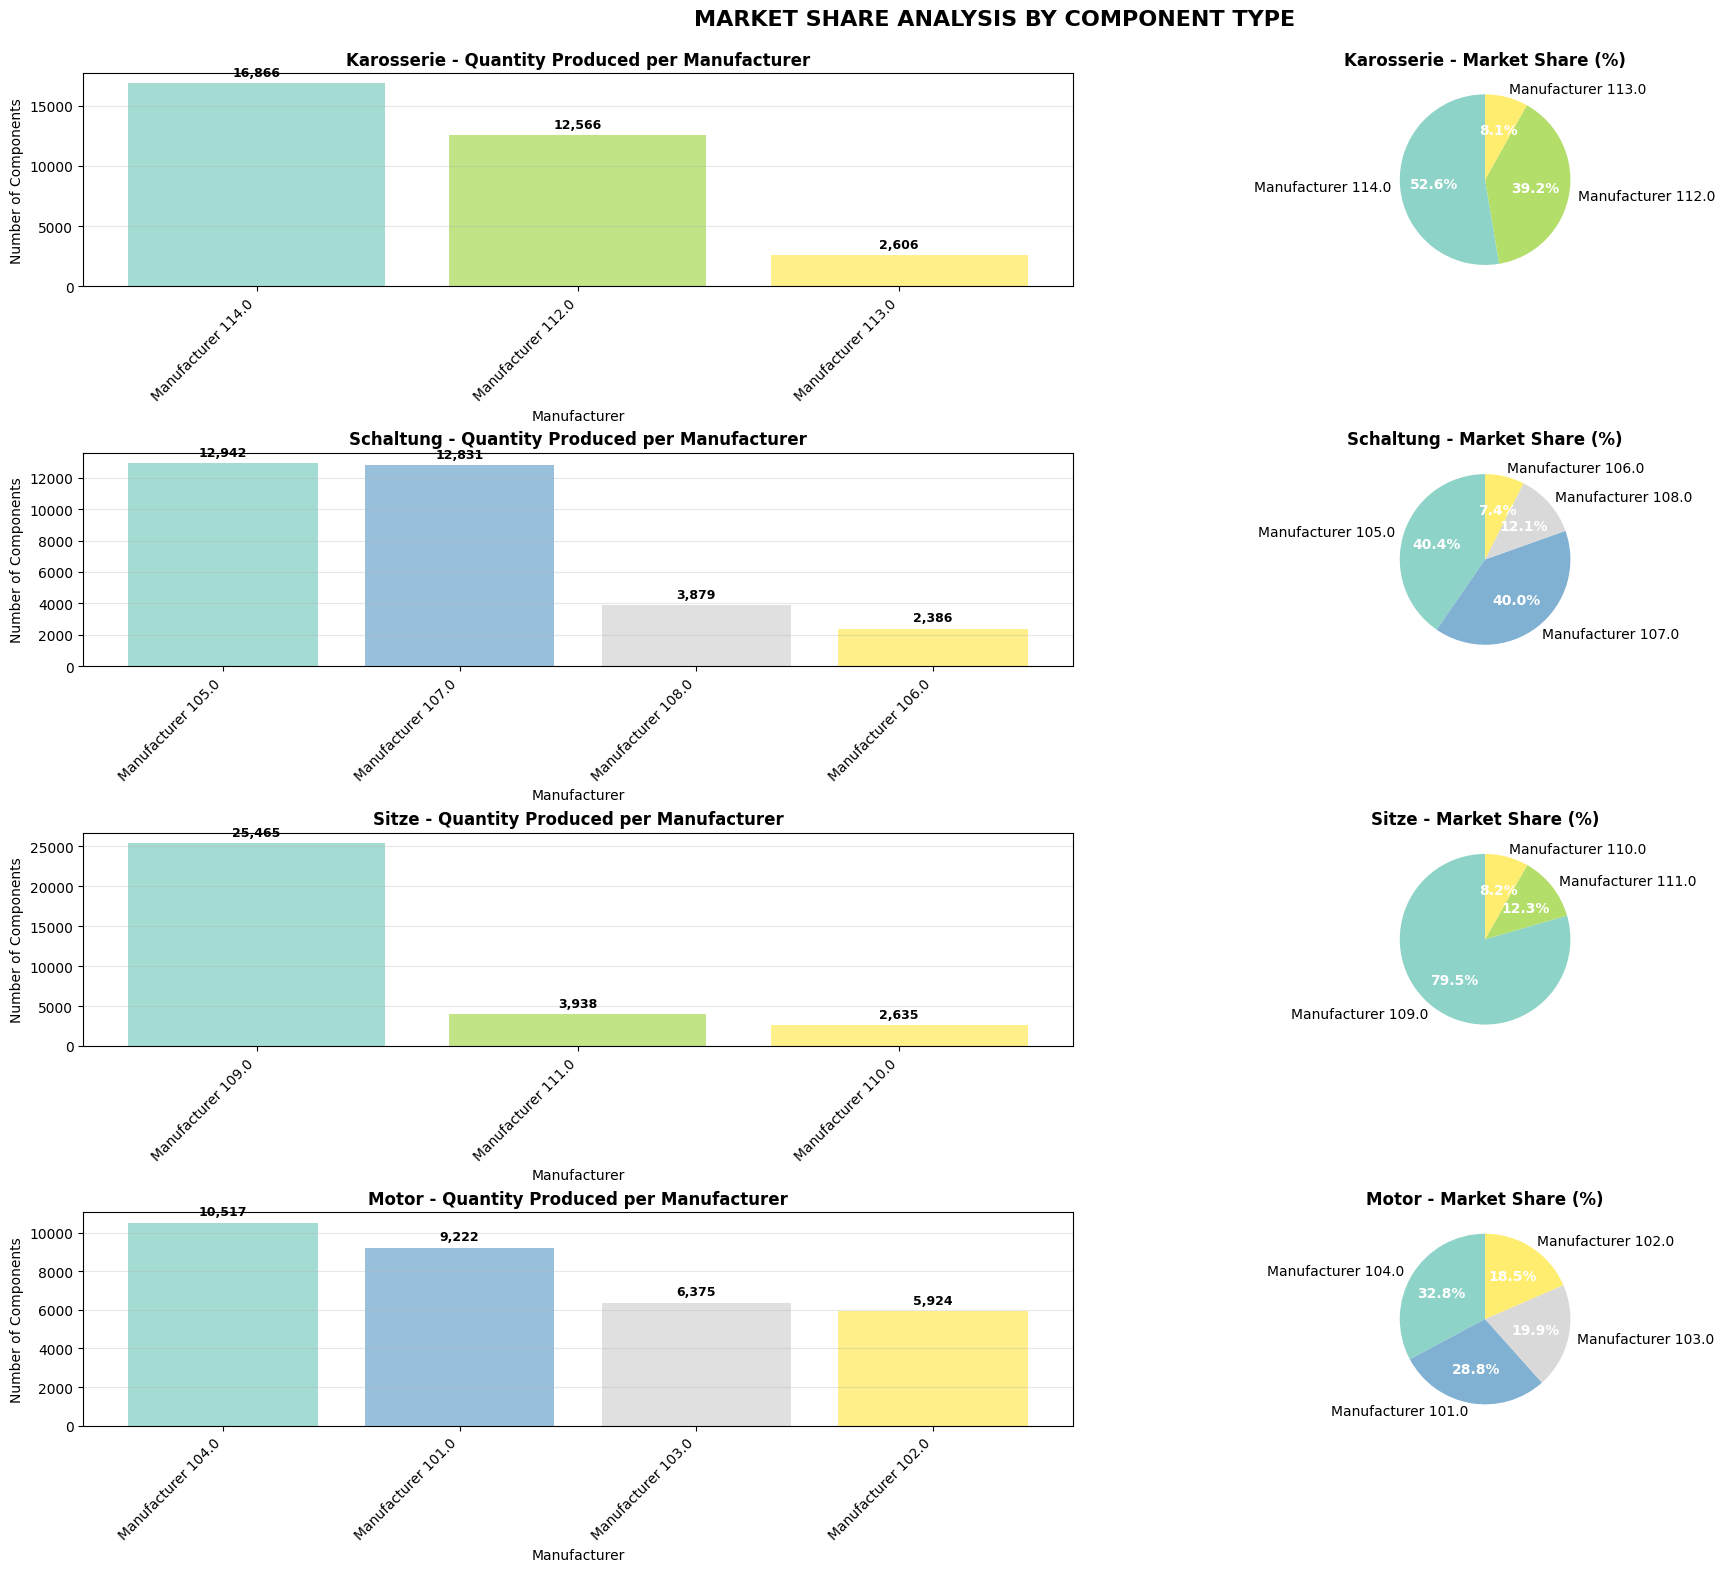

In [20]:
# =============================================================================
# CELL 1: MARKET SHARE AND QUANTITY PRODUCED BY COMPONENT TYPE
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define component types for analysis
component_columns = ['Karosserie', 'Schaltung', 'Sitze', 'Motor']

market_analysis = {}

for comp_type in component_columns:
    # Filter dataset for the current component type
    comp_data = df_manufacturers[df_manufacturers['Component_Type'] == comp_type].copy()
    
    if len(comp_data) == 0:
        print(f" No data available for {comp_type}")
        continue
    
    total_components = len(comp_data)
    unique_manufacturers = comp_data['Manufacturer'].nunique()
    
    # Compute market share per manufacturer
    manufacturer_counts = comp_data['Manufacturer'].value_counts()
    manufacturer_percentages = comp_data['Manufacturer'].value_counts(normalize=True) * 100
    
    market_analysis[comp_type] = {
        'data': comp_data,
        'counts': manufacturer_counts,
        'percentages': manufacturer_percentages,
        'total': total_components,
        'manufacturers': unique_manufacturers
    }

# =============================================================================
# COMPREHENSIVE MARKET SHARE VISUALIZATION
# =============================================================================

print("\nMARKET SHARE ANALYSIS")

fig = plt.figure(figsize=(20, 16))

for i, comp_type in enumerate(component_columns):
    if comp_type not in market_analysis:
        continue
        
    # Absolute quantities (left column)
    ax1 = plt.subplot(4, 2, i*2 + 1)
    counts = market_analysis[comp_type]['counts']
    colors = plt.cm.Set3(np.linspace(0, 1, len(counts)))
    
    bars = ax1.bar(range(len(counts)), counts.values, color=colors, alpha=0.8)
    ax1.set_title(f'{comp_type} - Quantity Produced per Manufacturer', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Manufacturer')
    ax1.set_ylabel('Number of Components')
    ax1.set_xticks(range(len(counts)))
    ax1.set_xticklabels([f'Manufacturer {x}' for x in counts.index], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Market share percentage (right column)
    ax2 = plt.subplot(4, 2, i*2 + 2)
    percentages = market_analysis[comp_type]['percentages']
    
    wedges, texts, autotexts = ax2.pie(percentages.values, 
                                       labels=[f'Manufacturer {x}' for x in percentages.index],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    
    ax2.set_title(f'{comp_type} - Market Share (%)', fontweight='bold', fontsize=12)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.suptitle('MARKET SHARE ANALYSIS BY COMPONENT TYPE', fontsize=16, fontweight='bold')
plt.show()


This notebook cell performs a **detailed lead time analysis by component type and manufacturer**, generating visualizations and summary statistics. The workflow is organized into three main analyses.

First, the script generates **boxplots of lead time distribution by component and manufacturer**. For each component type (`Karosserie`, `Schaltung`, `Sitze`, `Motor`), the dataset is filtered, and the lead times for each manufacturer are extracted. A boxplot is created for each component, with distinct colors for each manufacturer. This visualization highlights variation in lead times across manufacturers and identifies potential bottlenecks or outliers.

Second, it analyzes the **time span between the first and last part arrival** for each component. Using the `Parts_Date_Span` field, boxplots are generated per component and manufacturer, allowing comparison of production scheduling and part delivery consistency. Colors are mapped using a colormap to improve interpretability, and missing data is annotated in the plots to ensure clarity.

Third, the script examines **completion time from the last part arrival**. For each manufacturer, the average and median completion time are calculated, with results visualized as bar charts. Bars are color-coded to indicate buffer time (positive) or delay (negative), and annotated with exact values. This provides a quick overview of manufacturing efficiency and highlights manufacturers with potential delays.

Finally, **summary statistics by component type** are compiled. Key metrics include total components, unique manufacturers, average and median lead times, standard deviation, average parts span, and average completion time. The script identifies the best and worst manufacturer per component based on mean lead time, providing actionable insights for performance improvement. Metrics are formatted and displayed in a structured table, with additional performance comparisons printed for each component type.

Overall, this analysis enables evaluation of component-level supply chain performance, identifying variability across manufacturers, potential delays, and opportunities for optimization.


LEAD TIME ANALYSIS BY COMPONENT TYPE

1. LEAD TIME DISTRIBUTION BY COMPONENT TYPE


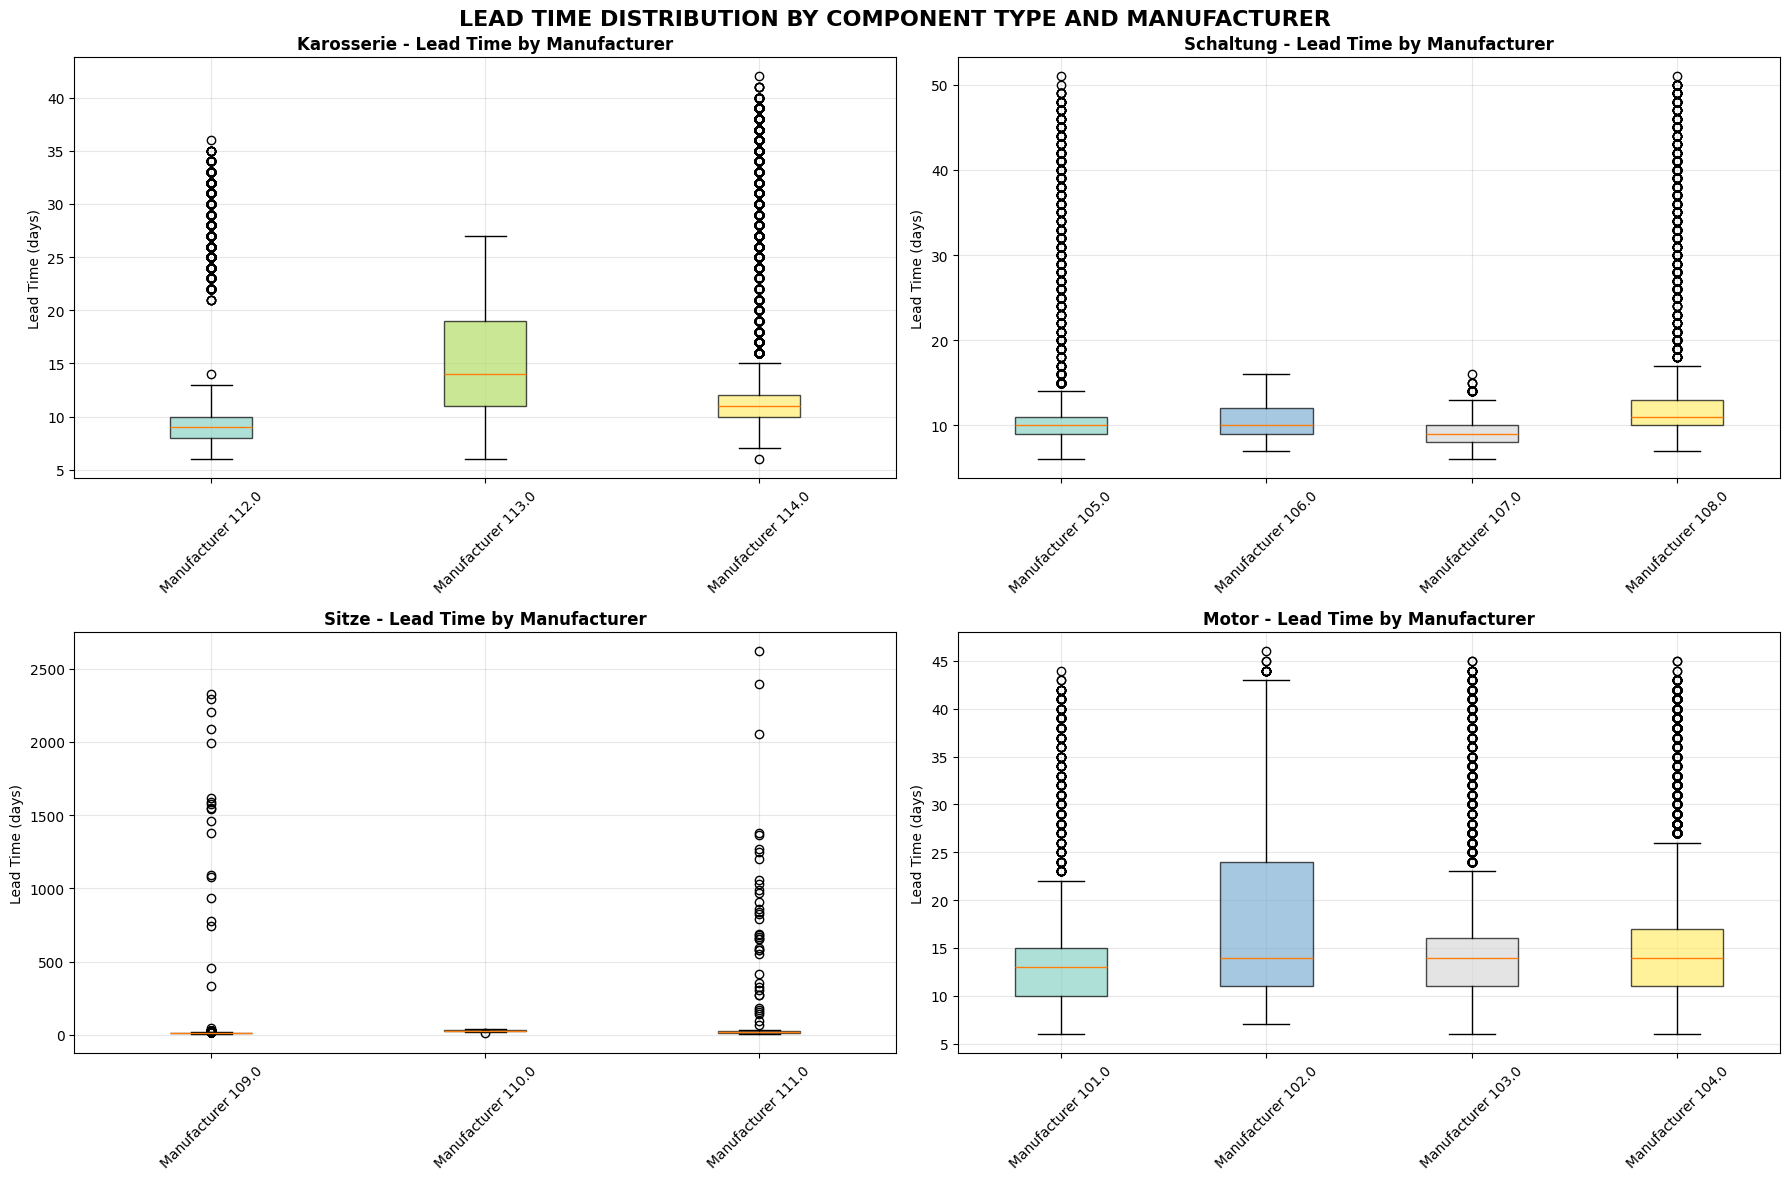


2. TIME BETWEEN FIRST AND LAST PART BY COMPONENT TYPE AND MANUFACTURER


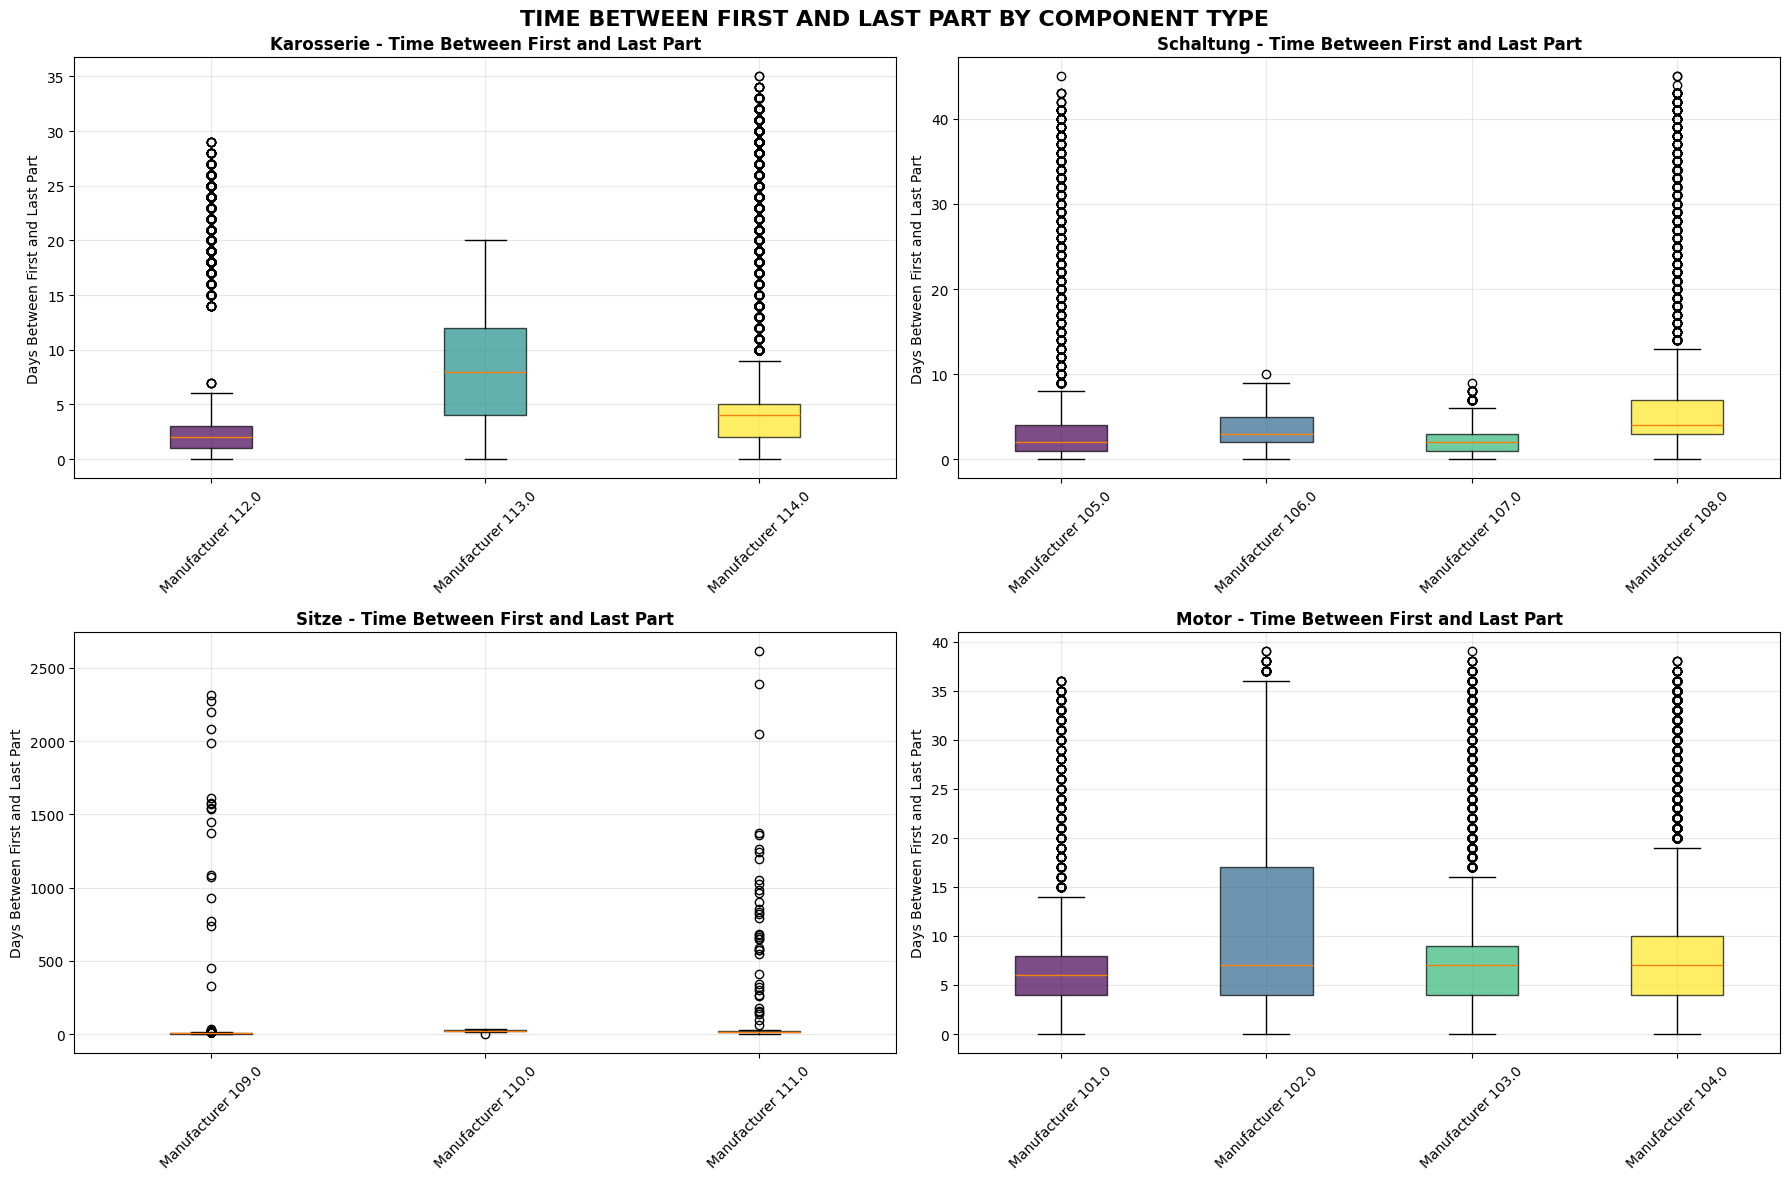


3. TIME TO COMPLETE COMPONENT FROM LAST PART ARRIVAL


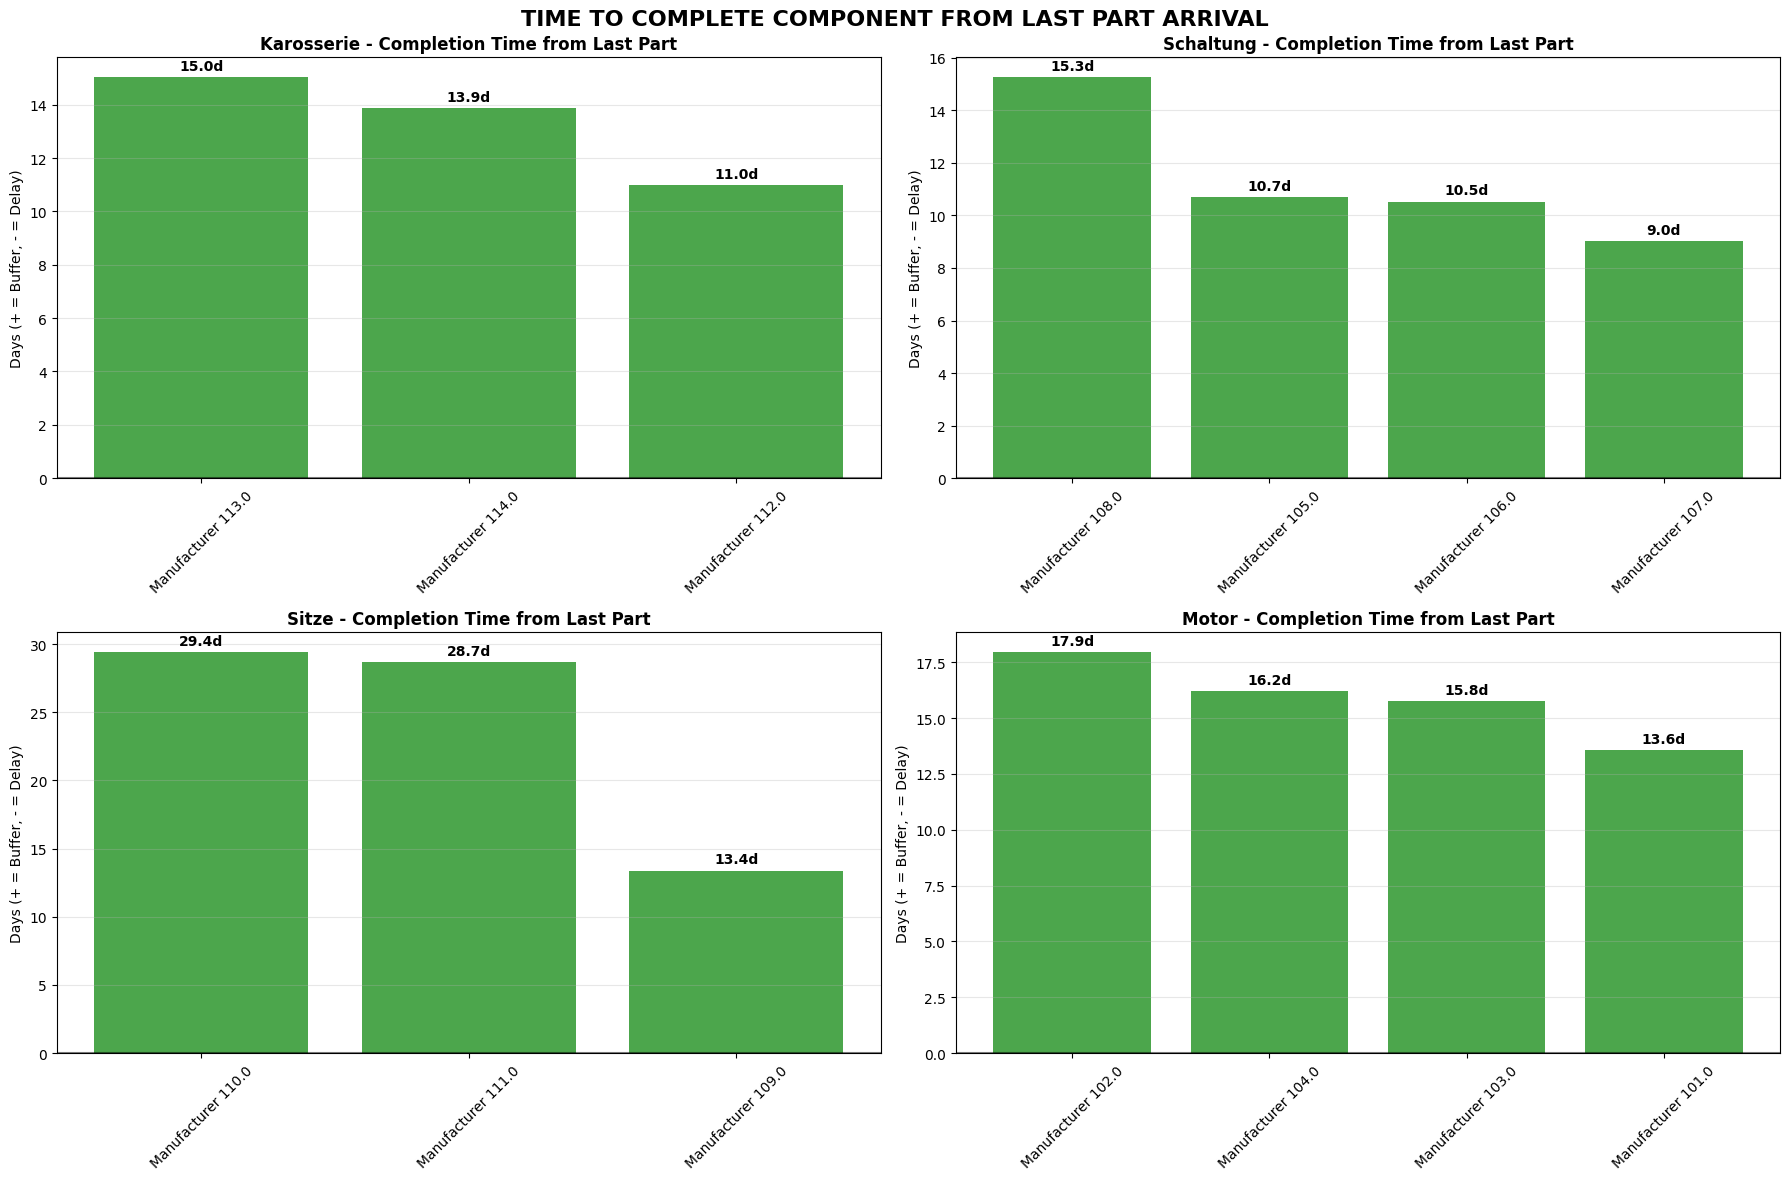


SUMMARY STATISTICS BY COMPONENT TYPE
Component_Type  Total_Components  Unique_Manufacturers  Avg_LeadTime  Avg_Parts_Span  Avg_Completion_Time  Best_Manufacturer  Best_LeadTime
    Karosserie             32038                     3          12.8             5.9                 12.8              112.0           11.0
     Schaltung             32038                     4          10.6             3.6                 10.6              107.0            9.0
         Sitze             32038                     3          16.6             9.9                 16.6              109.0           13.4
         Motor             32038                     4          15.7             8.9                 15.7              101.0           13.6

PERFORMANCE COMPARISON:

KAROSSERIE:
  Best Manufacturer: 112.0 (11.0 days)
  Worst Manufacturer: 113.0 (15.0 days)
  Average Lead Time: 12.8 ± 7.4 days
  Average Parts Span: 5.9 days
  Buffer Time: +12.8 days

SCHALTUNG:
  Best Manufacturer: 107.0 (9.0 days)
 

In [21]:
# =============================================================================
# CELL 2: LEAD TIME ANALYSIS BY COMPONENT TYPE
# =============================================================================

print("LEAD TIME ANALYSIS BY COMPONENT TYPE")
print("=" * 50)

component_columns = ['Karosserie', 'Schaltung', 'Sitze', 'Motor']

# =============================================================================
# 1. BOXPLOT OF LEAD TIME BY COMPONENT AND MANUFACTURER
# =============================================================================

print("\n1. LEAD TIME DISTRIBUTION BY COMPONENT TYPE")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('LEAD TIME DISTRIBUTION BY COMPONENT TYPE AND MANUFACTURER', 
             fontsize=16, fontweight='bold')

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, comp_type in enumerate(component_columns):
    ax = axes[positions[i][0], positions[i][1]]
    
    comp_data = df_manufacturers[df_manufacturers['Component_Type'] == comp_type].copy()
    
    if len(comp_data) == 0:
        ax.text(0.5, 0.5, f'No data for {comp_type}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    manufacturers = sorted(comp_data['Manufacturer'].unique())
    leadtime_data = []
    labels = []
    
    for mfg in manufacturers:
        mfg_leadtimes = comp_data[comp_data['Manufacturer'] == mfg]['Component_LeadTime']
        if len(mfg_leadtimes) > 0:
            leadtime_data.append(mfg_leadtimes)
            labels.append(f'Manufacturer {mfg}')
    
    if leadtime_data:
        bp = ax.boxplot(leadtime_data, tick_labels=labels, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(leadtime_data)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{comp_type} - Lead Time by Manufacturer', fontweight='bold', fontsize=12)
    ax.set_ylabel('Lead Time (days)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 2. BOX PLOT OF TIME BETWEEN FIRST AND LAST PART BY COMPONENT TYPE
# =============================================================================

print("\n2. TIME BETWEEN FIRST AND LAST PART BY COMPONENT TYPE AND MANUFACTURER")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('TIME BETWEEN FIRST AND LAST PART BY COMPONENT TYPE', 
             fontsize=16, fontweight='bold')

for i, comp_type in enumerate(component_columns):
    ax = axes[positions[i][0], positions[i][1]]
    
    comp_data = df_manufacturers[df_manufacturers['Component_Type'] == comp_type].copy()
    
    if len(comp_data) == 0:
        ax.text(0.5, 0.5, f'No data for {comp_type}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    manufacturers = sorted(comp_data['Manufacturer'].unique())
    parts_span_data = []
    labels = []
    
    for mfg in manufacturers:
        mfg_parts_span = comp_data[comp_data['Manufacturer'] == mfg]['Parts_Date_Span']
        if len(mfg_parts_span) > 0:
            parts_span_data.append(mfg_parts_span)
            labels.append(f'Manufacturer {mfg}')
    
    if parts_span_data:
        bp = ax.boxplot(parts_span_data, tick_labels=labels, patch_artist=True)
        colors = plt.cm.viridis(np.linspace(0, 1, len(parts_span_data)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{comp_type} - Time Between First and Last Part', fontweight='bold', fontsize=12)
    ax.set_ylabel('Days Between First and Last Part')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 3. TIME TO COMPLETE COMPONENT FROM LAST PART ARRIVAL
# =============================================================================

print("\n3. TIME TO COMPLETE COMPONENT FROM LAST PART ARRIVAL")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('TIME TO COMPLETE COMPONENT FROM LAST PART ARRIVAL', 
             fontsize=16, fontweight='bold')

for i, comp_type in enumerate(component_columns):
    ax = axes[positions[i][0], positions[i][1]]
    
    comp_data = df_manufacturers[df_manufacturers['Component_Type'] == comp_type].copy()
    
    if len(comp_data) == 0:
        ax.text(0.5, 0.5, f'No data for {comp_type}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    mfg_stats = []
    manufacturers = sorted(comp_data['Manufacturer'].unique())
    
    for mfg in manufacturers:
        mfg_data = comp_data[comp_data['Manufacturer'] == mfg]
        avg_completion_time = mfg_data['Latest_Part_LeadTime'].mean()
        median_completion_time = mfg_data['Latest_Part_LeadTime'].median()
        total_components = len(mfg_data)
        
        mfg_stats.append({
            'Manufacturer': mfg,
            'Avg_Completion_Time': avg_completion_time,
            'Median_Completion_Time': median_completion_time,
            'Total_Components': total_components
        })
    
    if mfg_stats:
        mfg_df = pd.DataFrame(mfg_stats).sort_values('Avg_Completion_Time', ascending=False)
        colors = ['green' if x >= 0 else 'red' for x in mfg_df['Avg_Completion_Time']]
        
        bars = ax.bar(range(len(mfg_df)), mfg_df['Avg_Completion_Time'], color=colors, alpha=0.7)
        
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.annotate(f'{height:.1f}d',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3 if height >= 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom' if height >= 0 else 'top', 
                        fontsize=10, fontweight='bold')
        
        ax.set_xticks(range(len(mfg_df)))
        ax.set_xticklabels([f'Manufacturer {x}' for x in mfg_df['Manufacturer']], rotation=45)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax.set_title(f'{comp_type} - Completion Time from Last Part', fontweight='bold', fontsize=12)
    ax.set_ylabel('Days (+ = Buffer, - = Delay)')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY STATISTICS BY COMPONENT TYPE
# =============================================================================

print("\nSUMMARY STATISTICS BY COMPONENT TYPE")
print("=" * 55)

summary_stats = []

for comp_type in component_columns:
    comp_data = df_manufacturers[df_manufacturers['Component_Type'] == comp_type].copy()
    
    if len(comp_data) == 0:
        continue
    
    total_components = len(comp_data)
    unique_manufacturers = comp_data['Manufacturer'].nunique()
    
    avg_leadtime = comp_data['Component_LeadTime'].mean()
    median_leadtime = comp_data['Component_LeadTime'].median()
    std_leadtime = comp_data['Component_LeadTime'].std()
    
    avg_parts_span = comp_data['Parts_Date_Span'].mean()
    avg_completion_time = comp_data['Latest_Part_LeadTime'].mean()
    
    mfg_leadtimes = comp_data.groupby('Manufacturer')['Component_LeadTime'].mean()
    best_mfg = mfg_leadtimes.idxmin()
    best_leadtime = mfg_leadtimes.min()
    worst_mfg = mfg_leadtimes.idxmax()
    worst_leadtime = mfg_leadtimes.max()
    
    summary_stats.append({
        'Component_Type': comp_type,
        'Total_Components': total_components,
        'Unique_Manufacturers': unique_manufacturers,
        'Avg_LeadTime': avg_leadtime,
        'Median_LeadTime': median_leadtime,
        'Std_LeadTime': std_leadtime,
        'Avg_Parts_Span': avg_parts_span,
        'Avg_Completion_Time': avg_completion_time,
        'Best_Manufacturer': best_mfg,
        'Best_LeadTime': best_leadtime,
        'Worst_Manufacturer': worst_mfg,
        'Worst_LeadTime': worst_leadtime
    })

if summary_stats:
    summary_df = pd.DataFrame(summary_stats)
    display_cols = ['Component_Type', 'Total_Components', 'Unique_Manufacturers', 
                   'Avg_LeadTime', 'Avg_Parts_Span', 'Avg_Completion_Time',
                   'Best_Manufacturer', 'Best_LeadTime']
    
    print(summary_df[display_cols].round(1).to_string(index=False))
    
    print("\nPERFORMANCE COMPARISON:")
    for _, row in summary_df.iterrows():
        print(f"\n{row['Component_Type'].upper()}:")
        print(f"  Best Manufacturer: {row['Best_Manufacturer']} ({row['Best_LeadTime']:.1f} days)")
        print(f"  Worst Manufacturer: {row['Worst_Manufacturer']} ({row['Worst_LeadTime']:.1f} days)")
        print(f"  Average Lead Time: {row['Avg_LeadTime']:.1f} ± {row['Std_LeadTime']:.1f} days")
        print(f"  Average Parts Span: {row['Avg_Parts_Span']:.1f} days")
        if row['Avg_Completion_Time'] >= 0:
            print(f"  Buffer Time: +{row['Avg_Completion_Time']:.1f} days")
        else:
            print(f"  Delay: {row['Avg_Completion_Time']:.1f} days")

print(f"\nCELL 2 COMPLETED: Lead time analysis for {len(component_columns)} component types")
